In [47]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import cycle
from scipy import stats
import seaborn as sns

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

### **Load the Dataset**.
<p> The pickle file is adapted from <a href="https://www.kaggle.com/lonnieqin/ubiquant-market-prediction-half-precision-pickle"><strong>Lonnie</strong></a> which is a reduced version of the original dataset. This speeds up loading and minimizes memory exhaustion</p>

In [2]:
# train df
train = pd.read_pickle('../input/ubiquant-market-prediction-half-precision-pickle/train.pkl')

In [3]:
train.head(5)

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079
2,6,0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,...,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,0.568848
3,7,0,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,...,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438,-1.064453
4,8,0,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,...,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793,-0.531738


*The train dataframe has 300 anonymized features and targets of investment ids at different time ids*

In [48]:
#  extracting the features of the df
n_features = 300
features = [f'f_{i}' for i in range(n_features)]

In [49]:
# what are the number of observations in the df?
# are there any nulls in the df?
obs = train.shape[0]
print(f"number of observations: {obs}")
print(f"NaNs in the dataframe? {str(train.isnull().values.any())}")

number of observations: 3141410
NaNs in the dataframe? False


In [50]:
# the number of investment ids, and max available time ids
# the investment_id with highest number of timesteps

obs_by_asset = train.groupby(['investment_id'])['target'].count()
assets = train.investment_id.nunique()
time_steps =train.time_id.nunique()
print(f"number of investments: {assets}\nmax time steps: {time_steps}")
print(f"highest observation time steps: investement_id {np.argmax(obs_by_asset)} with {np.max(obs_by_asset)}")
print(f"lowest observation time steps: investement_id {np.argmin(obs_by_asset)} with {np.min(obs_by_asset)}")


number of investments: 3579
max time steps: 1211
highest observation time steps: investement_id 2027 with 1211
lowest observation time steps: investement_id 1334 with 2


There  are 3579 investments. Investment 1334 has the lowest observation time steps of 2 whereas investment 2027 has highest observation time steps of 1211

In [108]:
# finding the quartiles of the time steps 

obs_by_asset.quantile([0.25,0.5,0.75])



0.25     683.0
0.50    1009.0
0.75    1131.0
Name: target, dtype: float64

50% of the investments have time steps between 0 and 683 for lower quartile and 1131 and 1211 for Q3.
The rest are between median value of 1009 and Q3

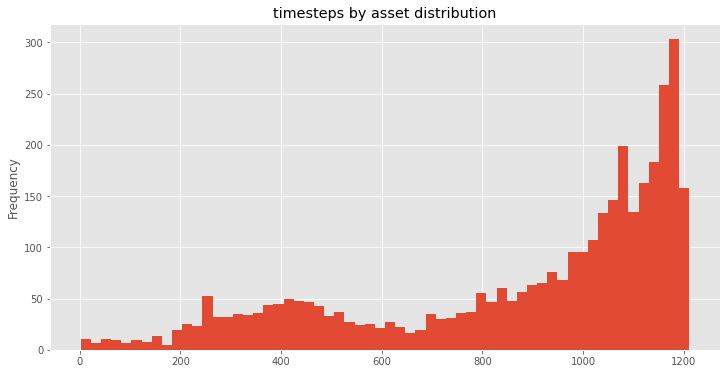

In [51]:
# timesteps per investment distribution

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
obs_by_asset.plot.hist(bins=60)
plt.title("timesteps by asset distribution")
plt.show()

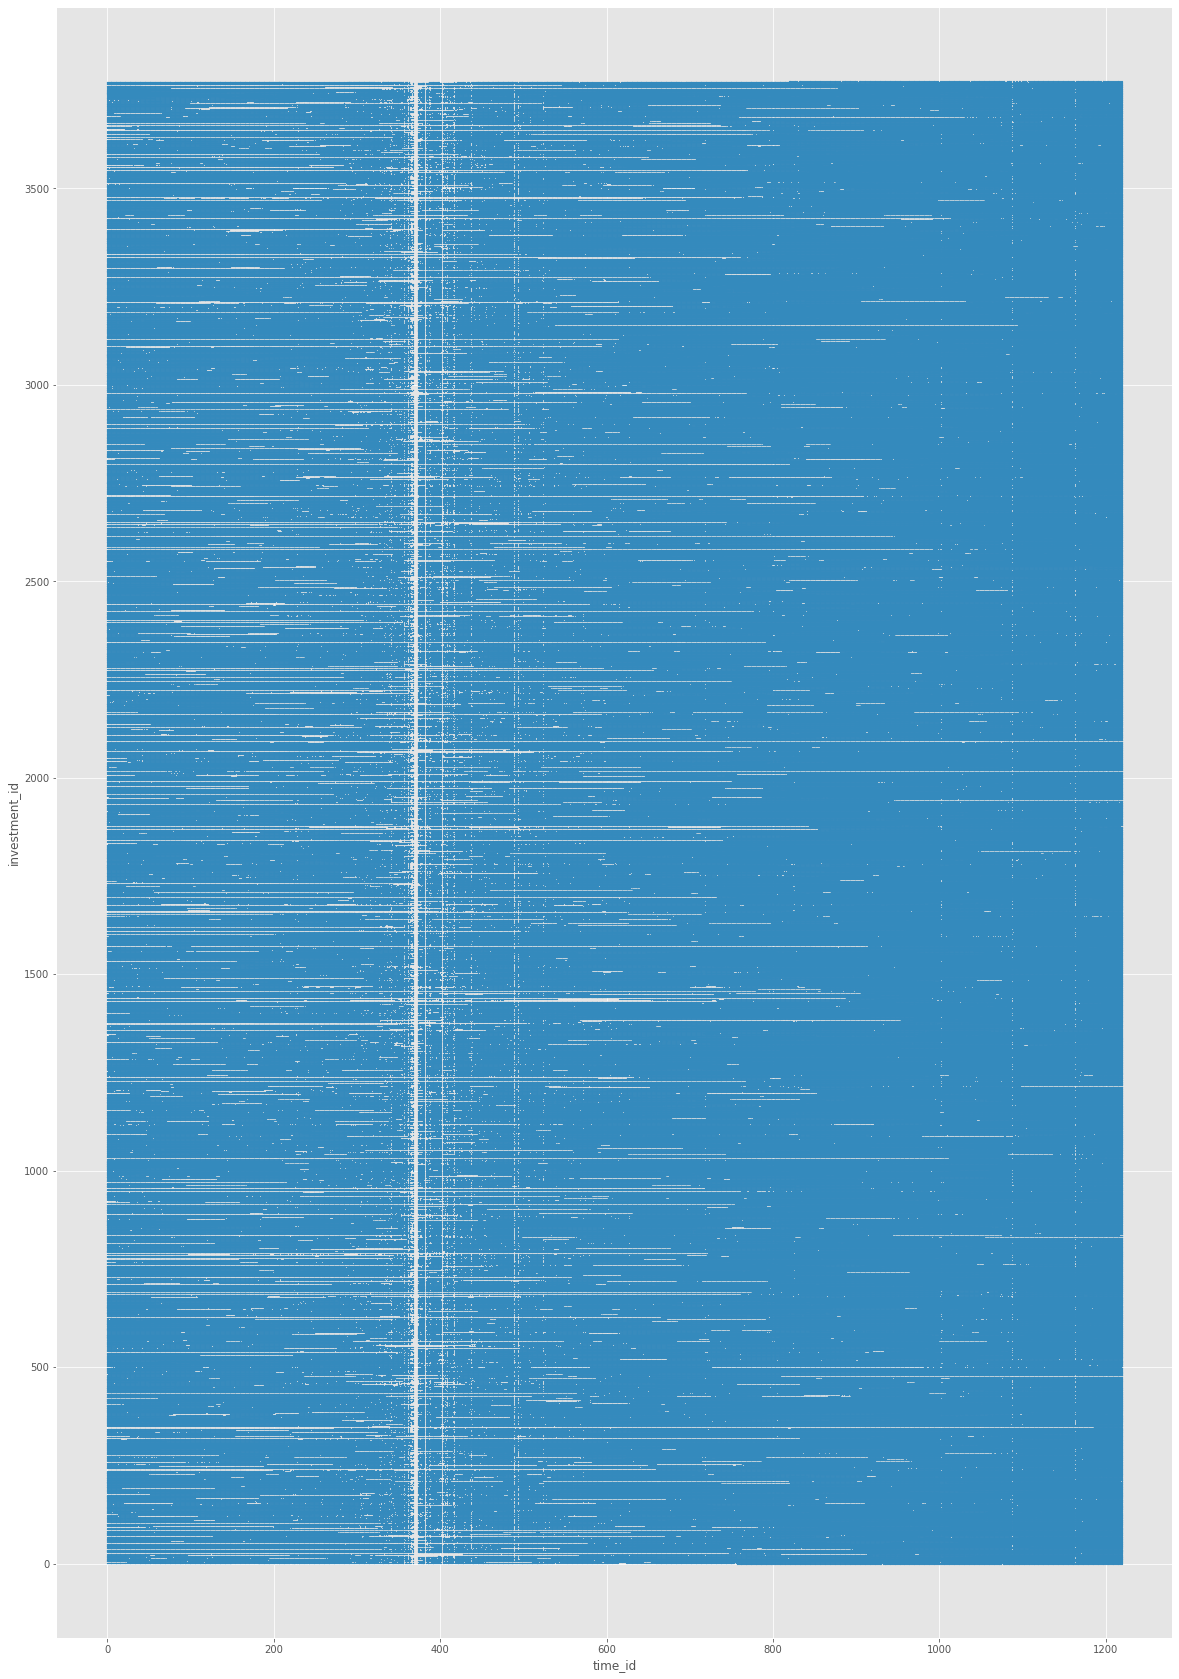

In [52]:
#  the time steps of the assets vary. 
# we plot the scatter of investments across the different time steps
train[['investment_id', 'time_id']].plot.scatter('time_id', 'investment_id', figsize=(20, 30), s=0.5)
plt.show()

The white patches shows missing data at the specific time id. The are some vertical white lines which are common across the various observations. These are probably holidays, missing or removed data to add noise to the datasets.

## **Targets**

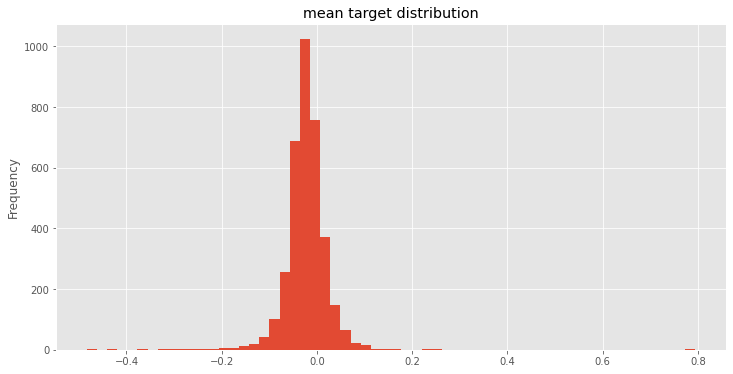

Mean of mean target: -0.02310


In [53]:
# The mean of the targets of each asset
mean_target = train.groupby(['investment_id'])['target'].mean()

# mean of the entire observation targets
mean_mean_target =mean_target.mean()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
mean_target.plot.hist(bins=60)
plt.title("mean target distribution")
plt.show()

print(f"Mean of mean target: {mean_mean_target: 0.5f}")

The distribution of targets is normal with a mean of almost zero. There are no outliers causing long tails.

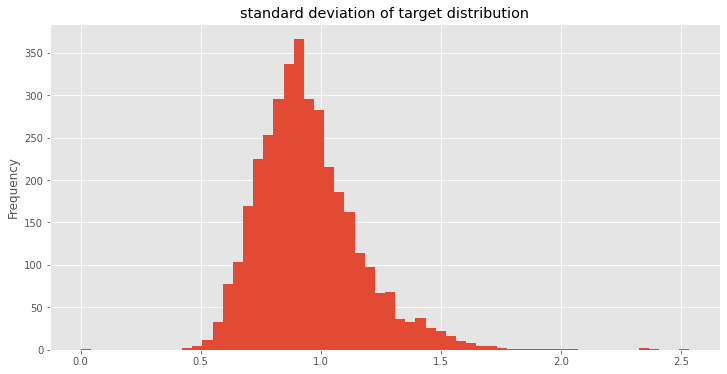

Mean of std target:  0.94790


In [54]:
# the standard deviation of the tragets of the specific investment id

sts_target = train.groupby(['investment_id'])['target'].std()

# the mean of the std of the targets
mean_std_target = np.mean(sts_target)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sts_target.plot.hist(bins=60)
plt.title("standard deviation of target distribution")
plt.show()

print(f"Mean of std target: {mean_std_target: 0.5f}")

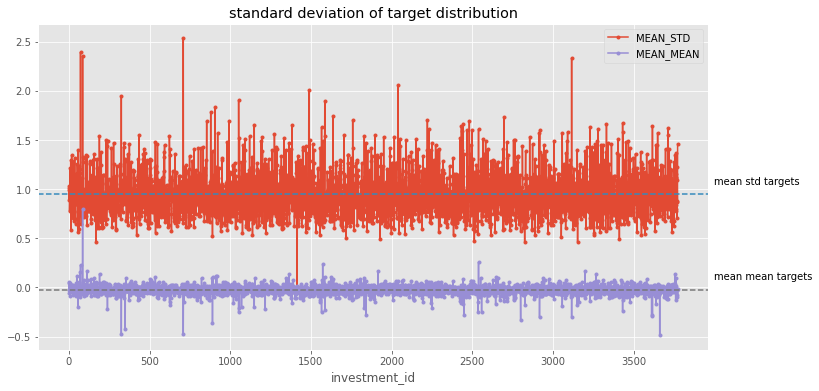

In [61]:
#  A plot of the std and the mean of each each asset
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sts_target.plot(style='.-',color=next(color_cycle),legend=True,label='MEAN_STD')
ax.axhline(y=mean_std_target,linestyle='--',color=next(color_cycle))
ax.text(4000,mean_std_target+0.1,'mean std targets')

ax.text(4000,mean_mean_target+0.1,'mean mean targets')
mean_target.plot(style='.-',color=,legend=True,label='MEAN_MEAN')
ax.axhline(y=mean_mean_target,linestyle='--',color=next(color_cycle))
plt.title("standard deviation of target distribution")
plt.show()

The plot of mean of asset targets is about zero, and confirm distribution of targets as normal. However, there exists a few targets with exceptionally high mean standard deviation. These targets possible have outliers or noise.

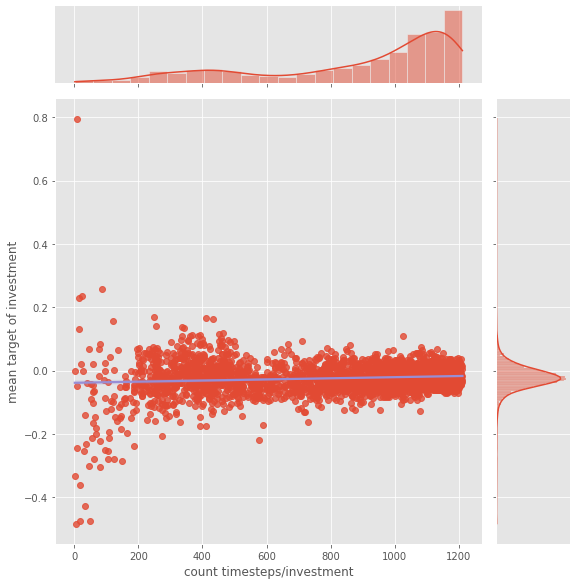

In [125]:
#  obs by target is a count of the time steps per investment id

ax = sns.jointplot(x=obs_by_asset.values, y=mean_target, kind="reg", 
                   height=8, joint_kws={'line_kws':{'color':next(color_cycle)}})
ax.ax_joint.set_xlabel('count timesteps/investment')
ax.ax_joint.set_ylabel('mean target of investment')
plt.show()

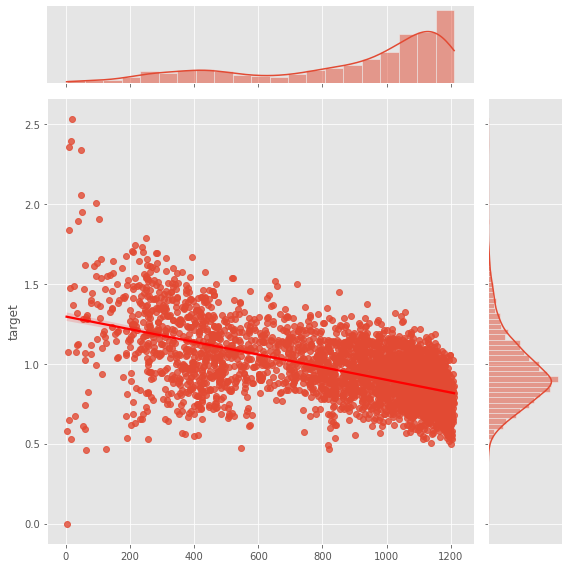

In [126]:
#  the count of investment time steps against mean std of each investment

qx = sns.jointplot(x=obs_by_asset.values, y=sts_target, kind="reg", 
                   height=8, joint_kws={'line_kws':{'color':'red'}})
ax.ax_joint.set_xlabel('observations')
ax.ax_joint.set_ylabel('std target')
plt.show()

From the join plot of counts and mean std of investments, as the time steps increases, std decreases.
This is in contrast to counts vs mean of std, where it's relatively constant

In [121]:
# does time id affect the targets?
#  we find the correlation of the time id and the targets

r = np.corrcoef(train.groupby('time_id')['investment_id'].nunique(), train.groupby('time_id')['target'].mean())[0][1]
print(f"Correlation of number of assets by target: {r:0.3f}")

Correlation of number of assets by target: -0.184


Looks like the targets of investments at specific time steps are not correlated

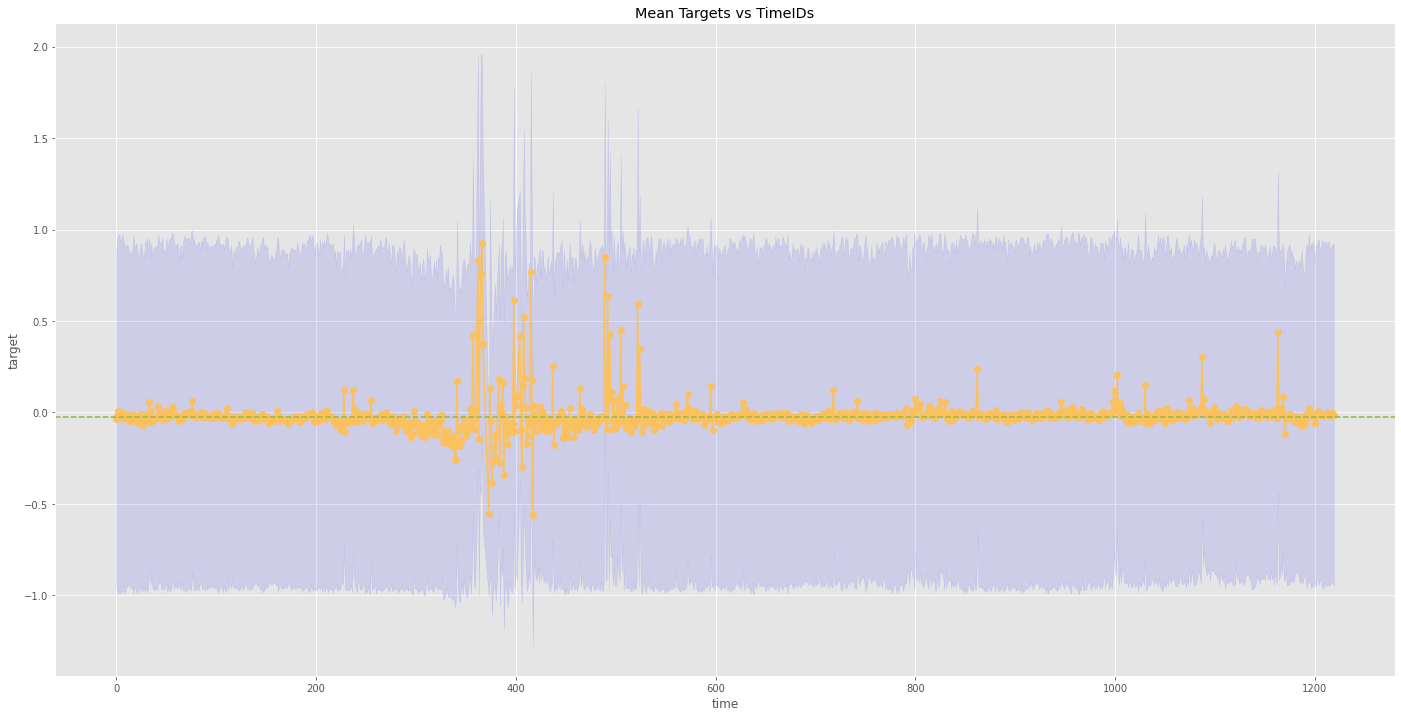

In [131]:
time2target_mean = train.groupby(['time_id'])['target'].mean() #mean of targets at specific time ids
time2target_std = train.groupby(['time_id'])['target'].std()  #std of targets at each time id

_, axes = plt.subplots(1, 1, figsize=(24, 12))

# fills the region between the minimum mean and maximum mean of the investments
plt.fill_between(
        time2target_mean.index,
        time2target_mean - time2target_std,
        time2target_mean + time2target_std,
        alpha=0.1,
        color="b",
    )

plt.plot(
        time2target_mean.index, time2target_mean, "o-", color=next(color_cycle), label="Training score"
    )
plt.axhline(y=mean_mean_target, color=next(color_cycle), linestyle='--', label="mean")
plt.title("Mean Targets vs TimeIDs")
axes.set_ylabel("target")
axes.set_xlabel("time")
plt.show()

There is spiking in average of the mean between time id 380 to 500, and also a huge variation in mean compared to other regions where the targets appear to be uniform in their mean. In this region, probably, there are missing data points for the majority of the investment ids.

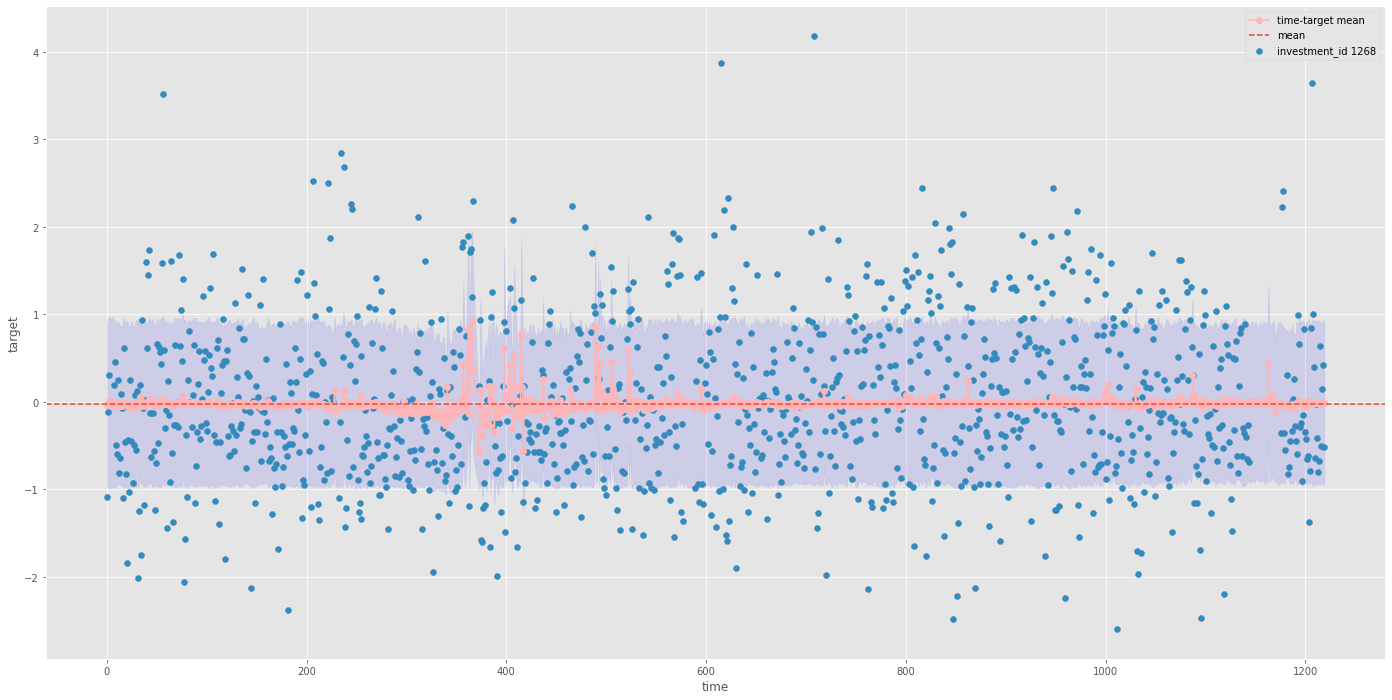

In [141]:
# a random investment id is 
time2target_mean = train.groupby(['time_id'])['target'].mean()
time2target_std = train.groupby(['time_id'])['target'].std()

_, axes = plt.subplots(1, 1, figsize=(24, 12))
plt.fill_between(
        time2target_mean.index,
        time2target_mean - time2target_std,
        time2target_mean + time2target_std,
        alpha=0.1,
        color="b",
    )
plt.plot(
        time2target_mean.index, time2target_mean, "o-", color=next(color_cycle), label="time-target mean"
    )
plt.axhline(y=mean_mean_target, color=next(color_cycle), linestyle='--', label="mean")

asset = np.random.randint(0,train.investment_id.nunique())
plt.scatter(train[train.investment_id==asset].time_id,
               train[train.investment_id==asset].target, color=next(color_cycle),label=f'investment_id {asset}')
plt.legend()

axes.set_ylabel("target")
axes.set_xlabel("time")
plt.show()

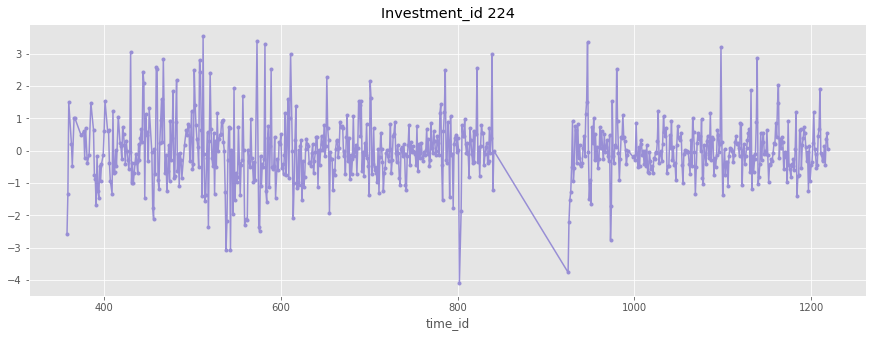

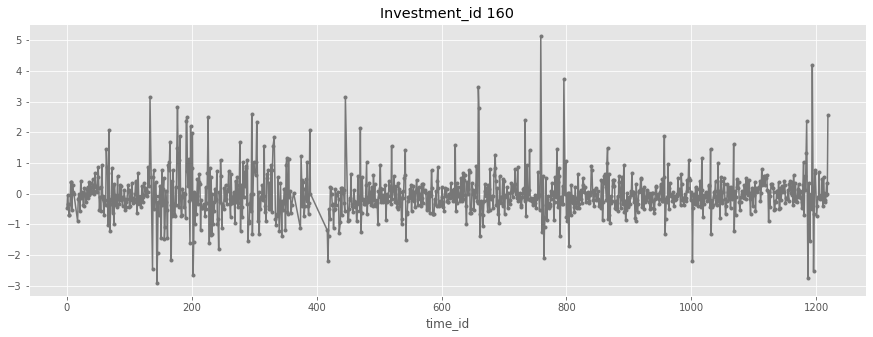

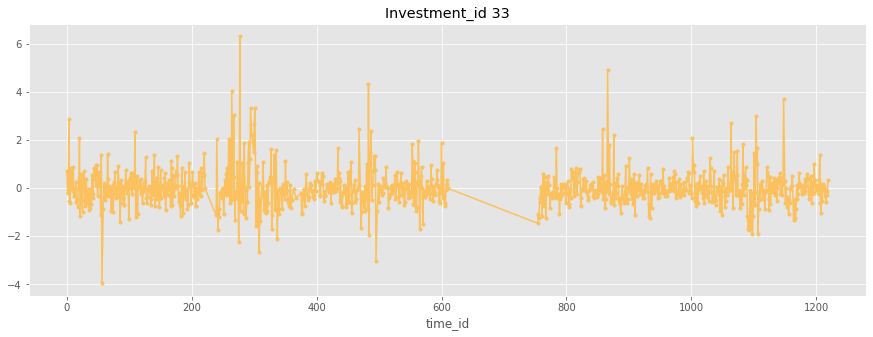

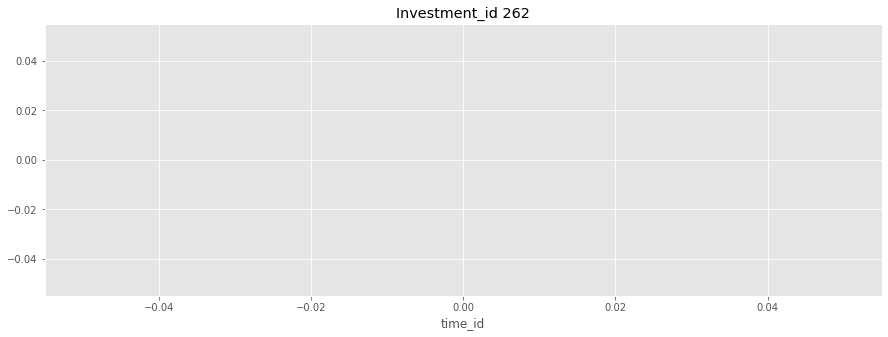

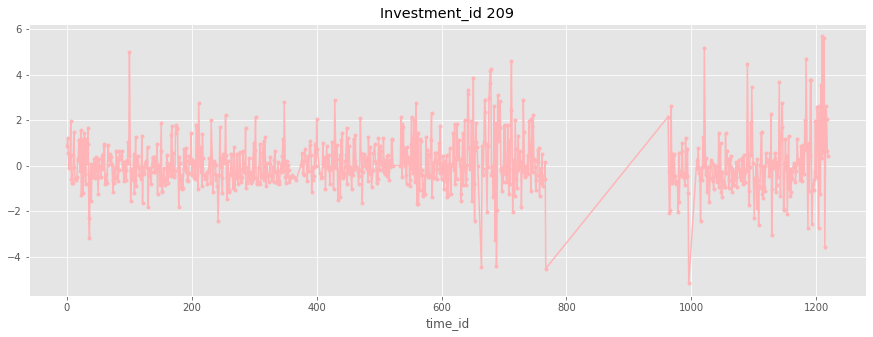

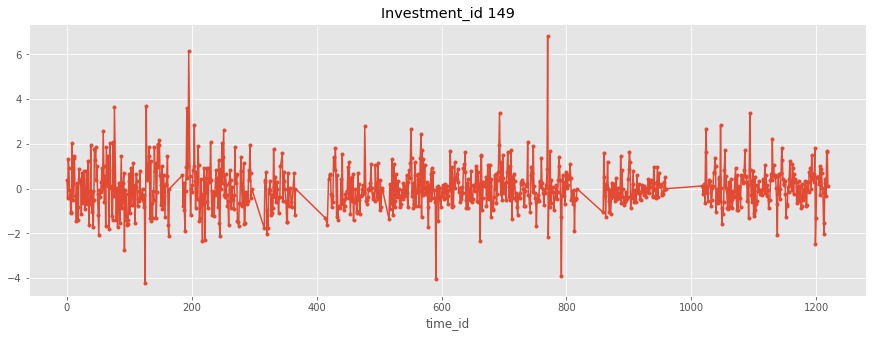

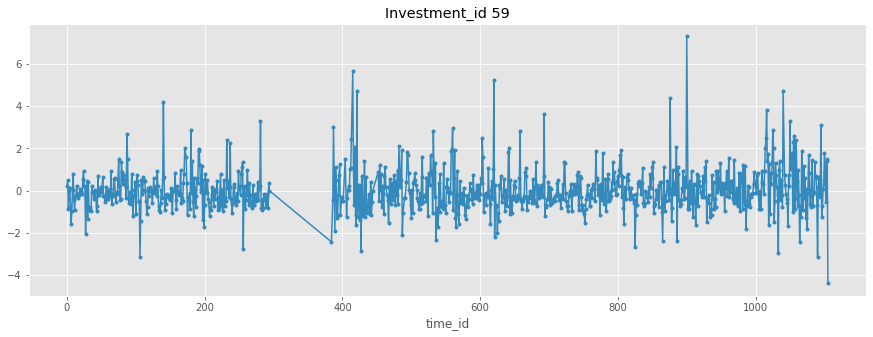

In [63]:
# we are plotting the random investment ids against time ids

random_investments = set(list(np.random.randint(0,300) for num in range(7)))

for investment_id in random_investments:
    d = train.query('investment_id == @investment_id')
    d.set_index('time_id')['target'] \
        .plot(figsize=(15, 5),
              title=f'Investment_id {investment_id}',
              color=next(color_cycle),
              style='.-')
    plt.show()

The plots of random assets indicate missing data gaps in the time ids. Some of them such as investment 262 has completely no data points

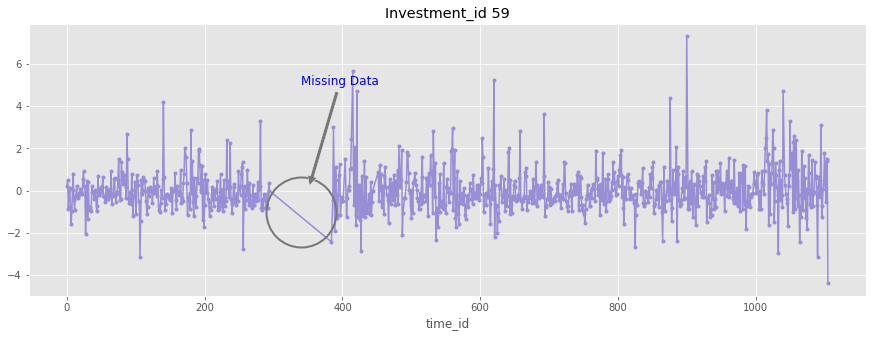

In [86]:
from matplotlib.patches import Ellipse
# a plot of investment_id 59
investment_id=59

fig, ax = plt.subplots(1, 1,figsize=(15, 5))
d = train.query('investment_id == @investment_id')

d.set_index('time_id')['target'] \
    .plot(title=f'Investment_id {investment_id}',
          color=next(color_cycle),
          style='.-')

circle_rad = 35  # This is the radius, in points
color = next(color_cycle)
ax.plot(340, -1, 'o',
        ms=circle_rad * 2, mec=color, mfc='none', mew=2)
ax.annotate('Missing Data', xy=(350,0), xytext=(340, 5),
            color='b', size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.3,head_width=0.8,head_length=0.8',
                facecolor=color, shrinkB=circle_rad * 0.15))

plt.show()

## **Features[f_0 - f_300]**

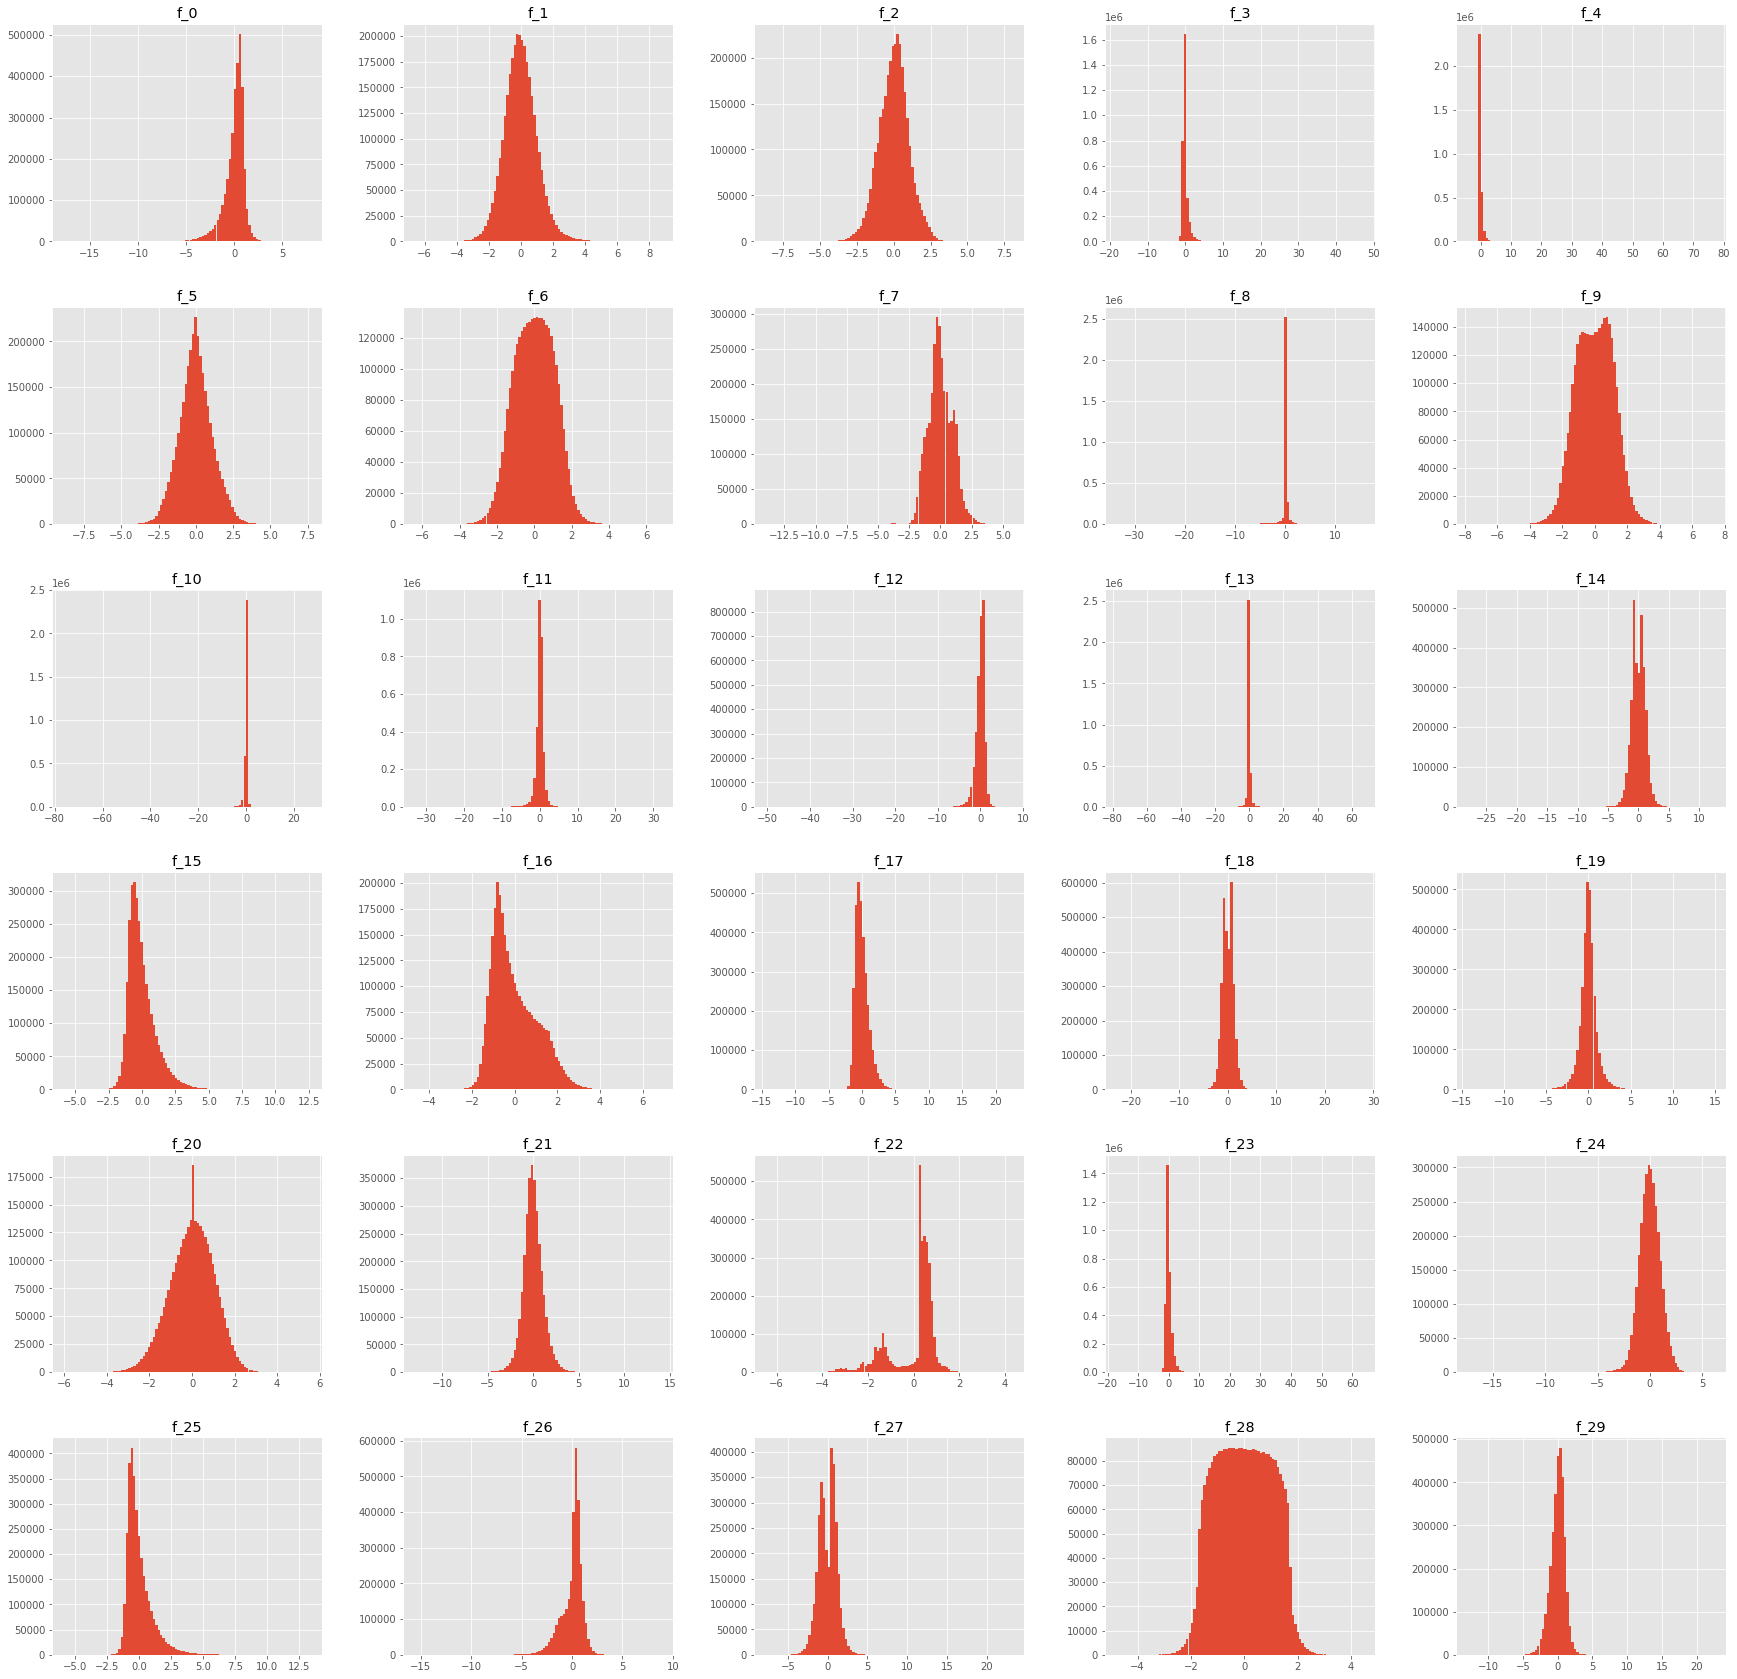

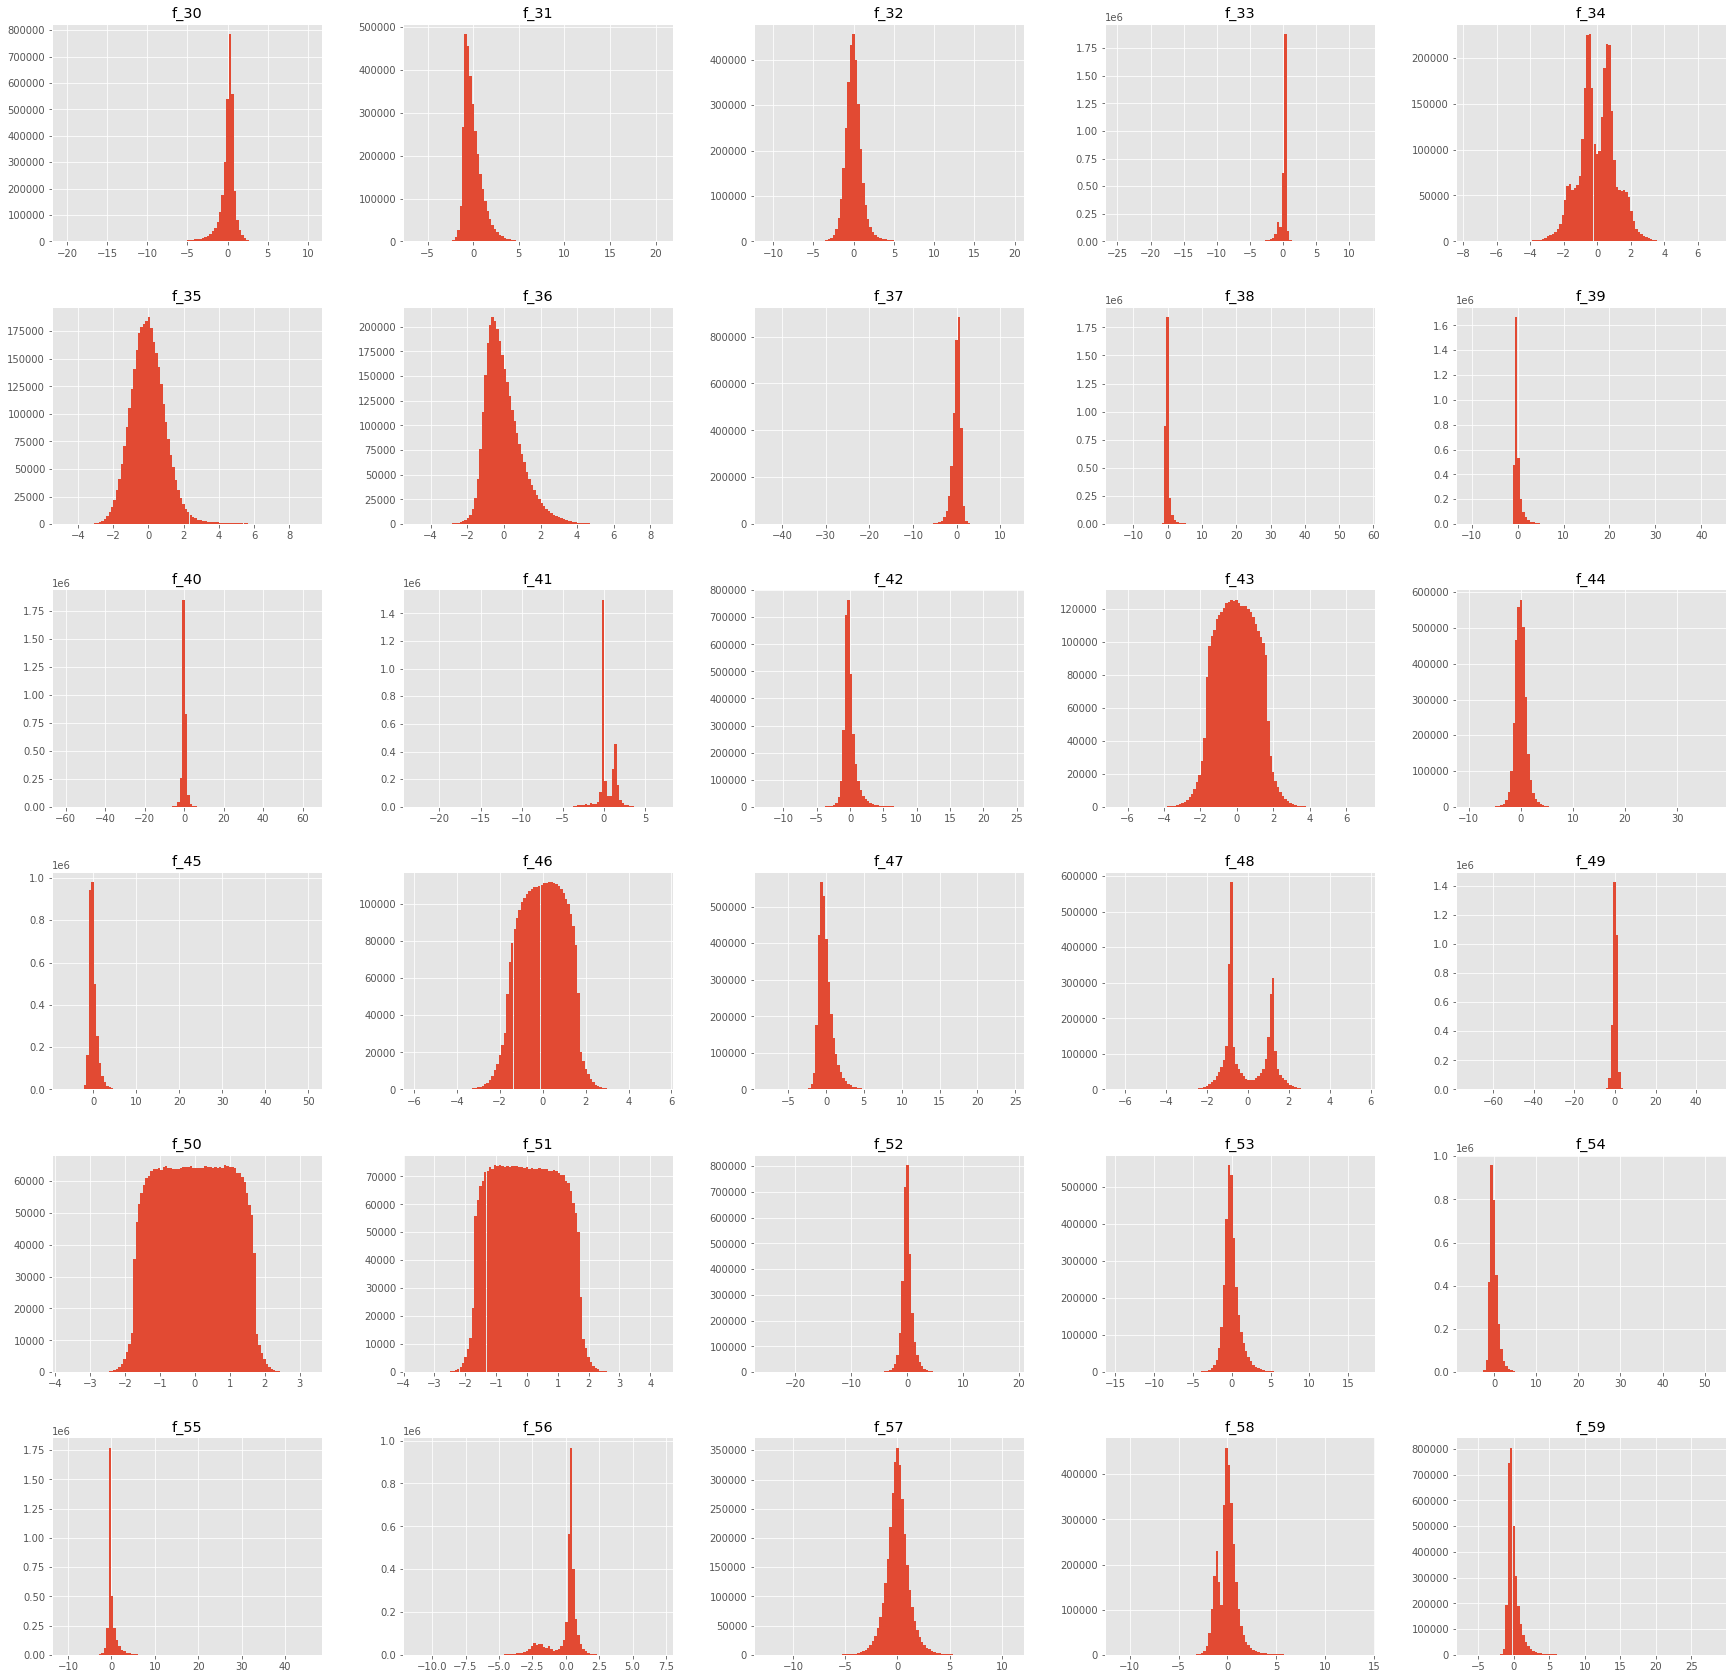

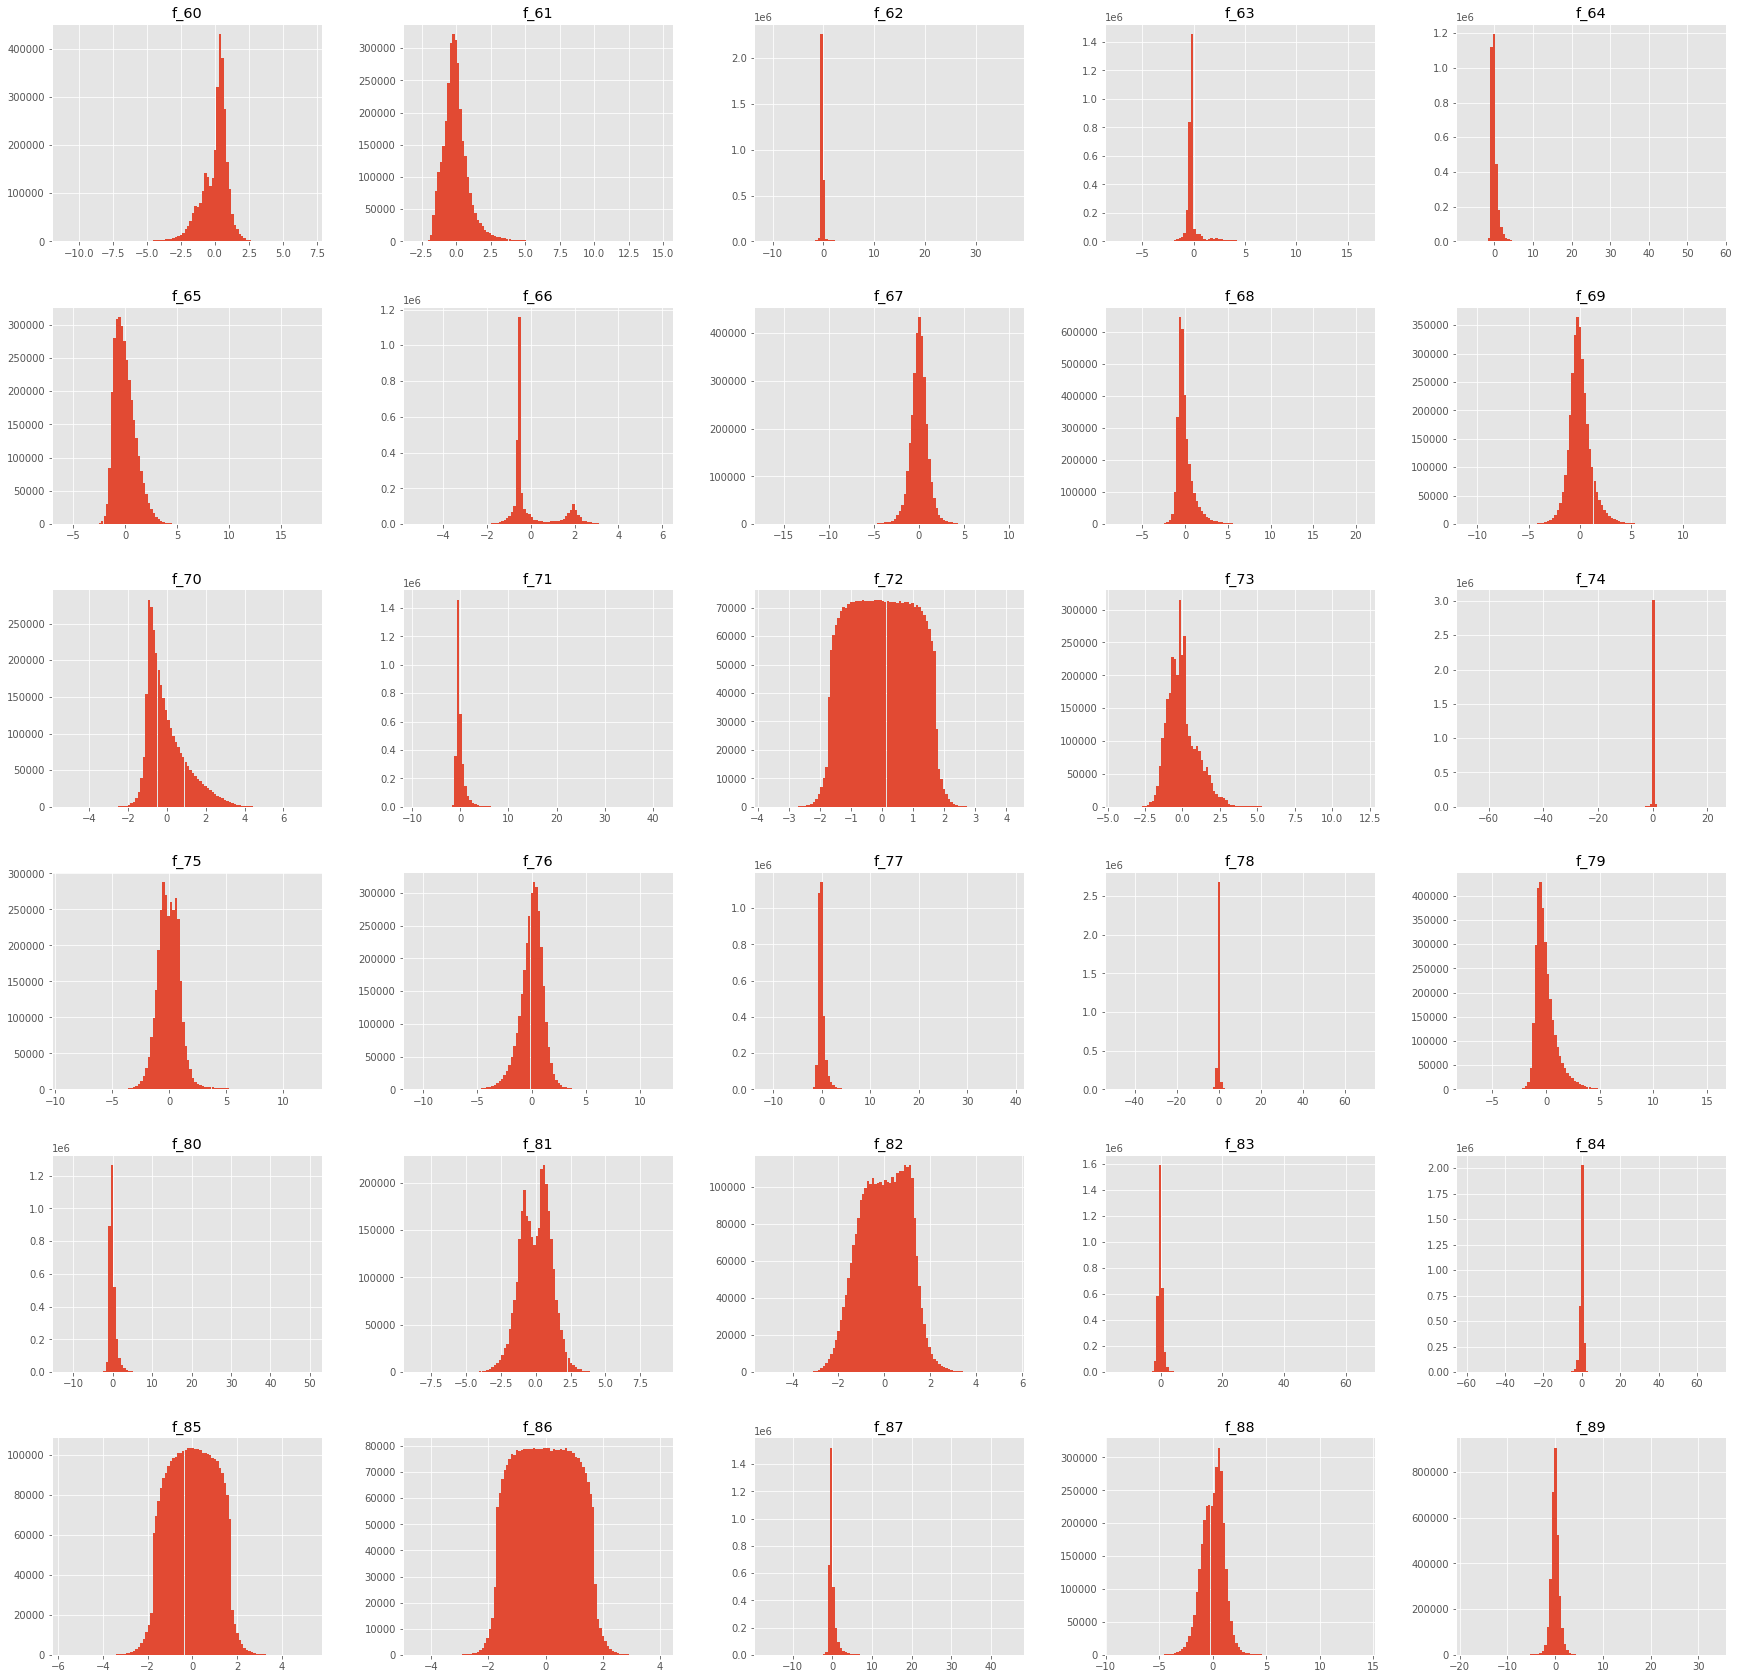

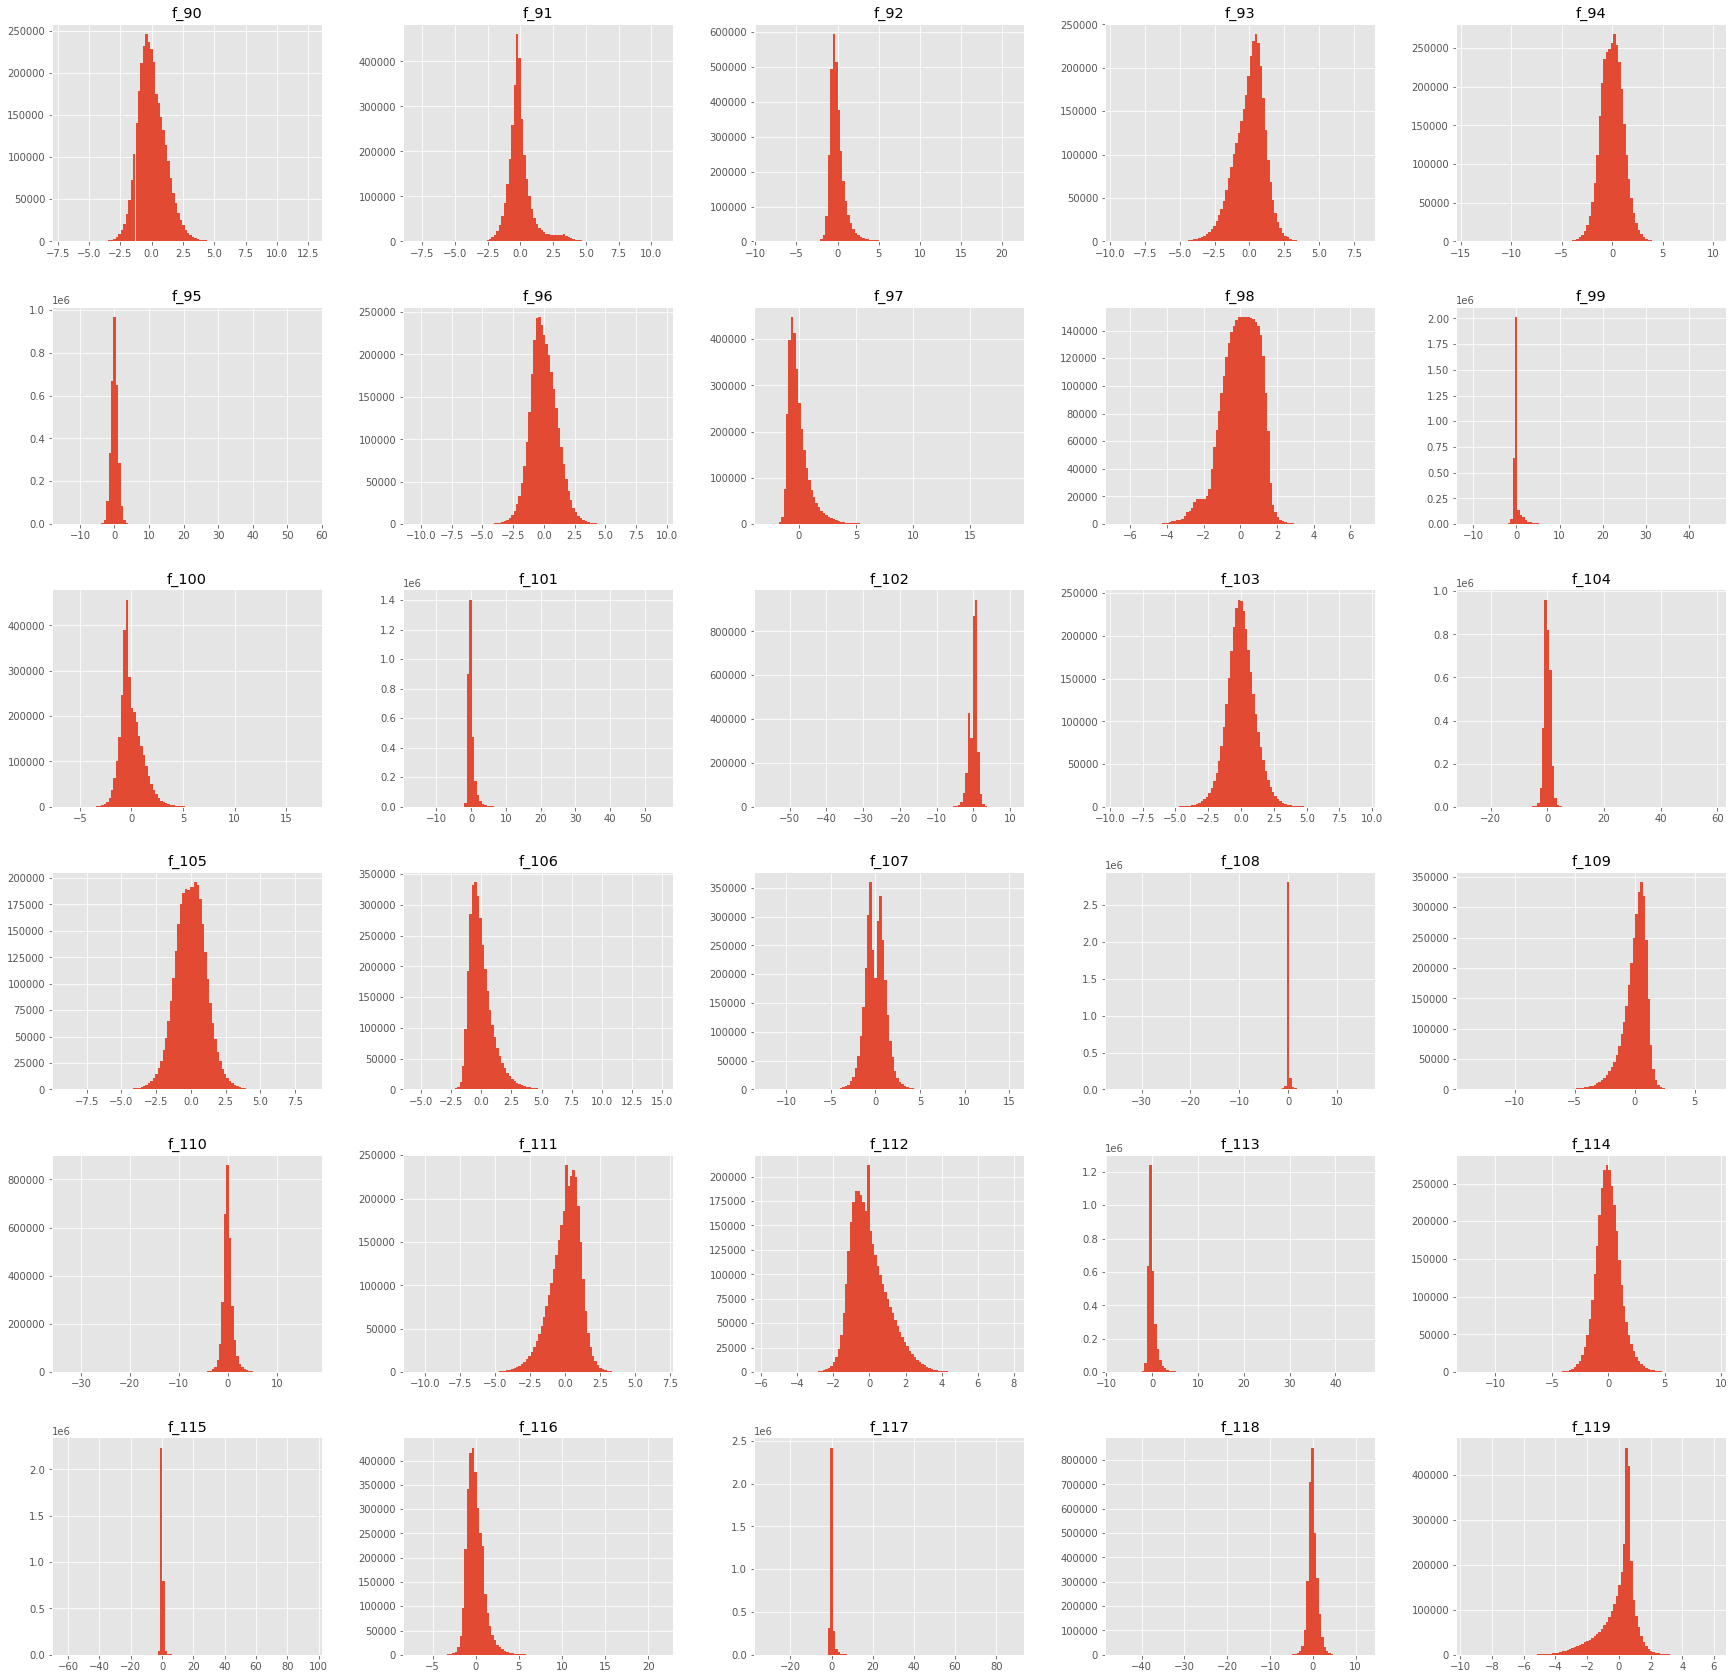

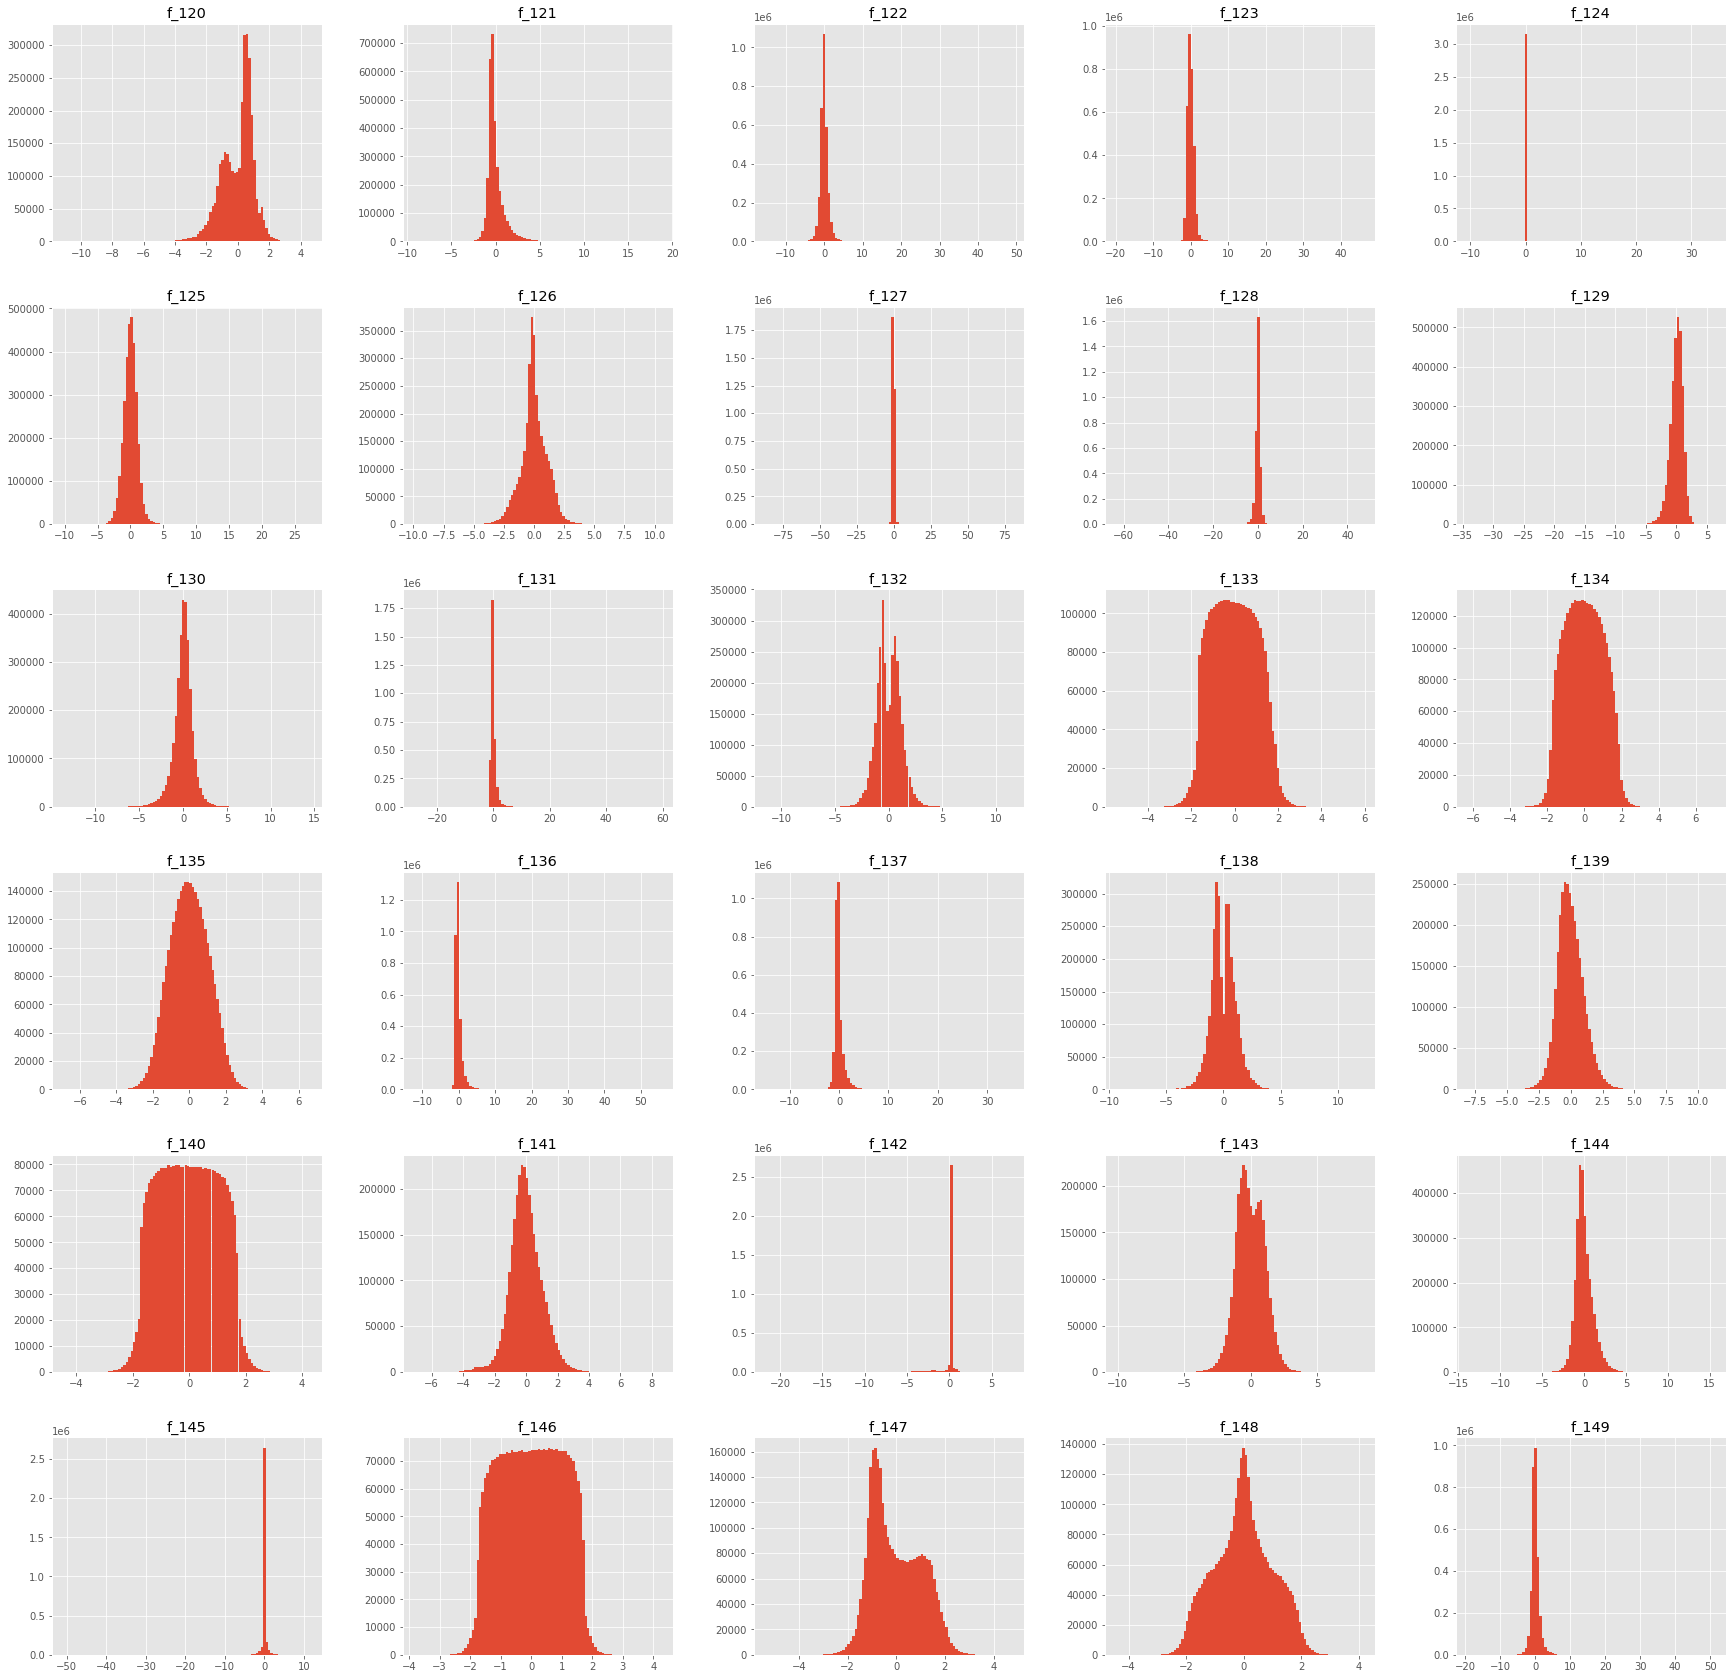

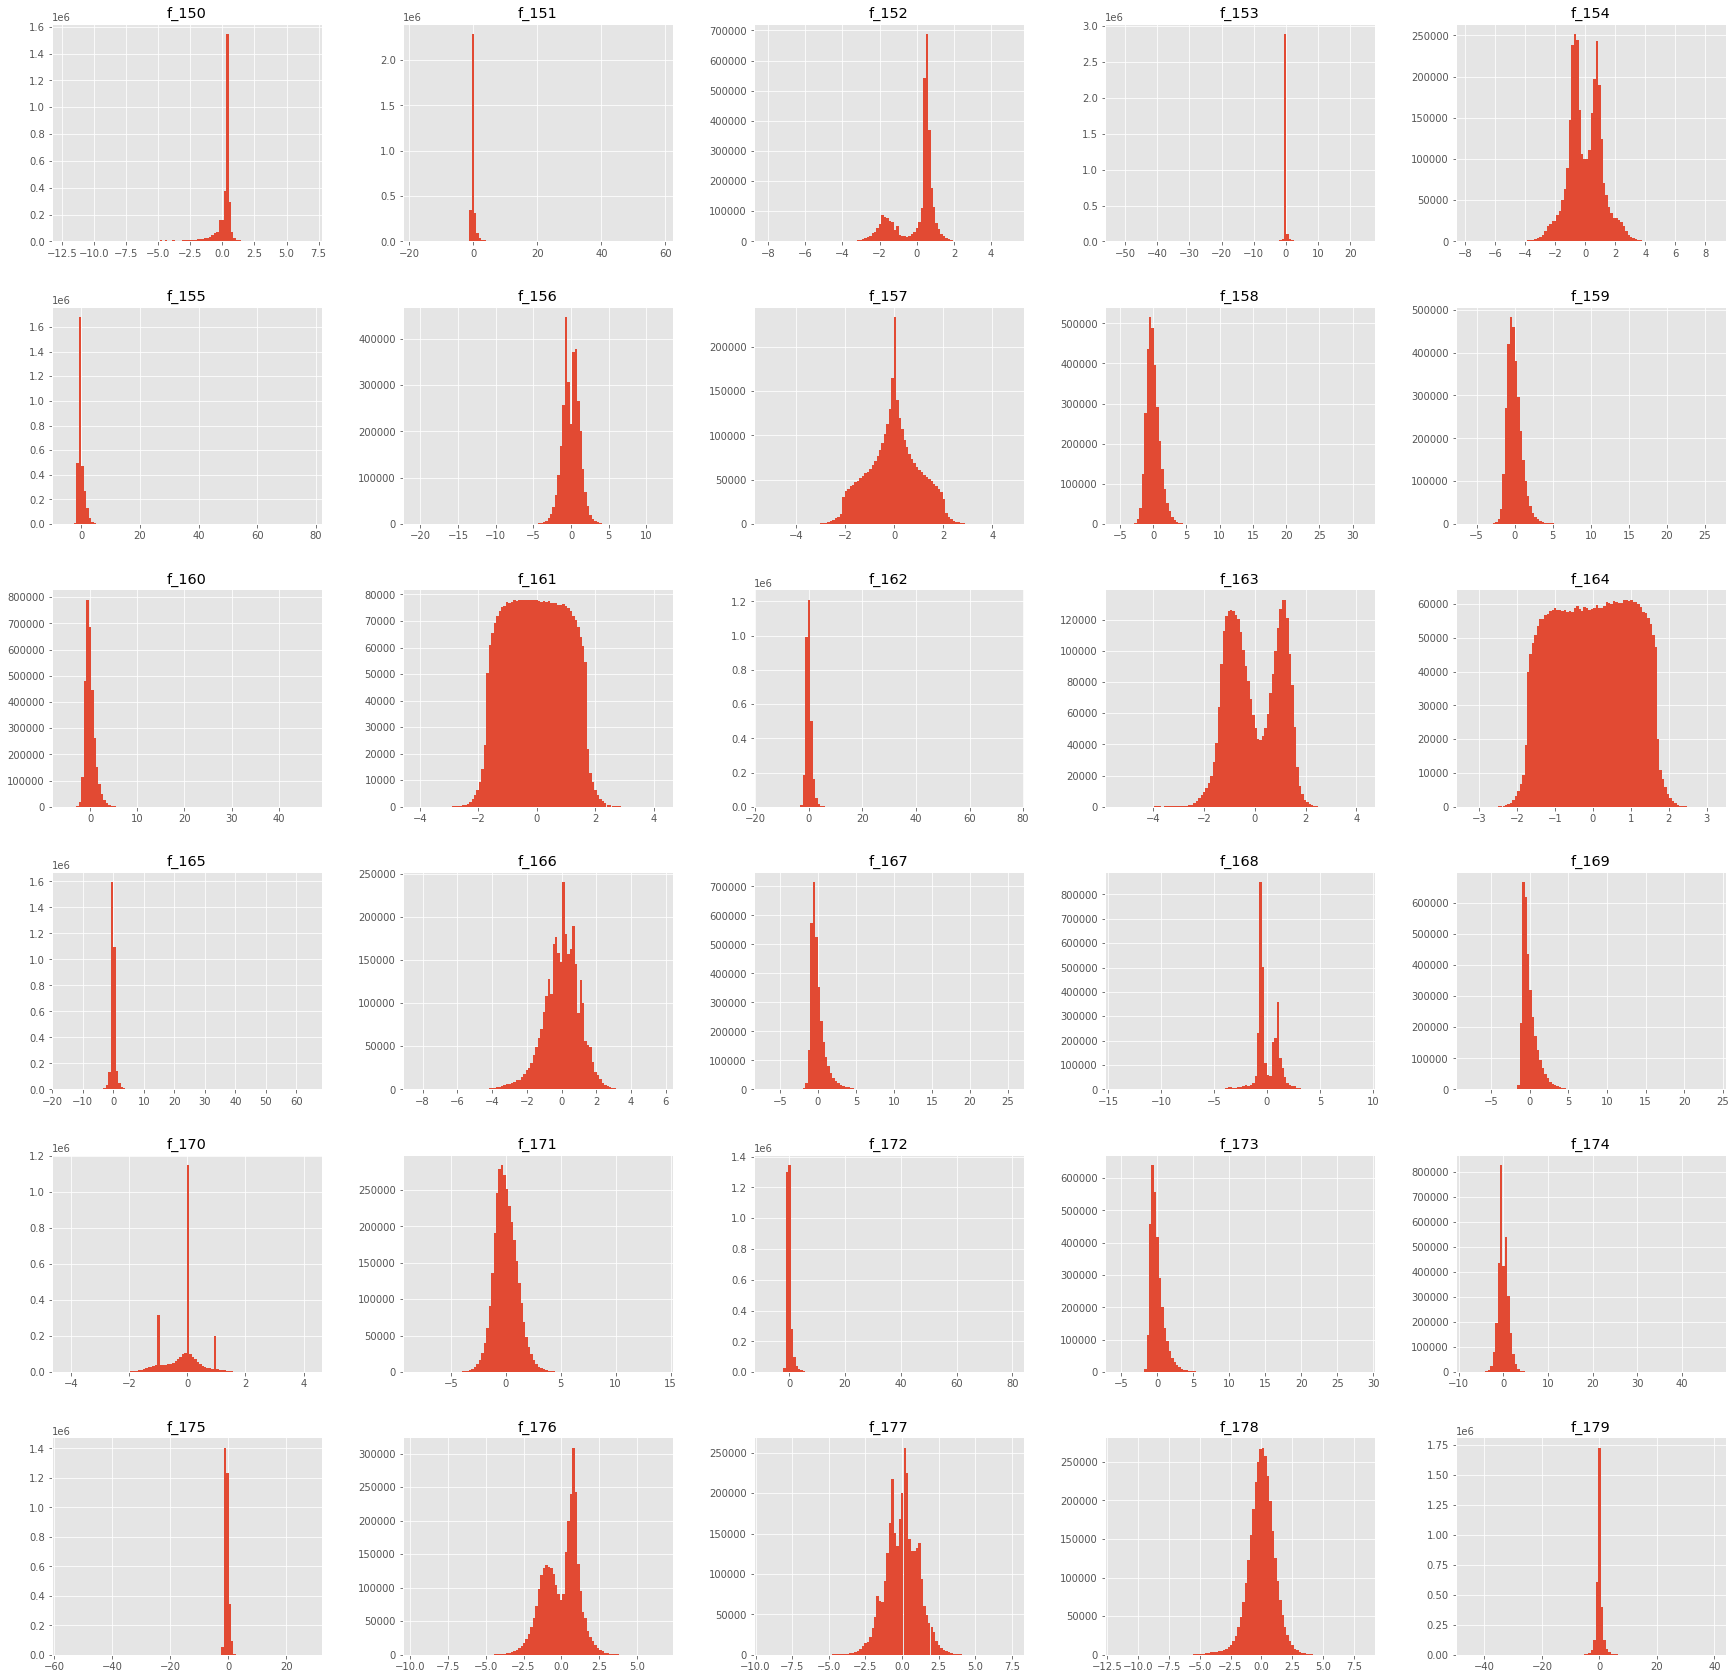

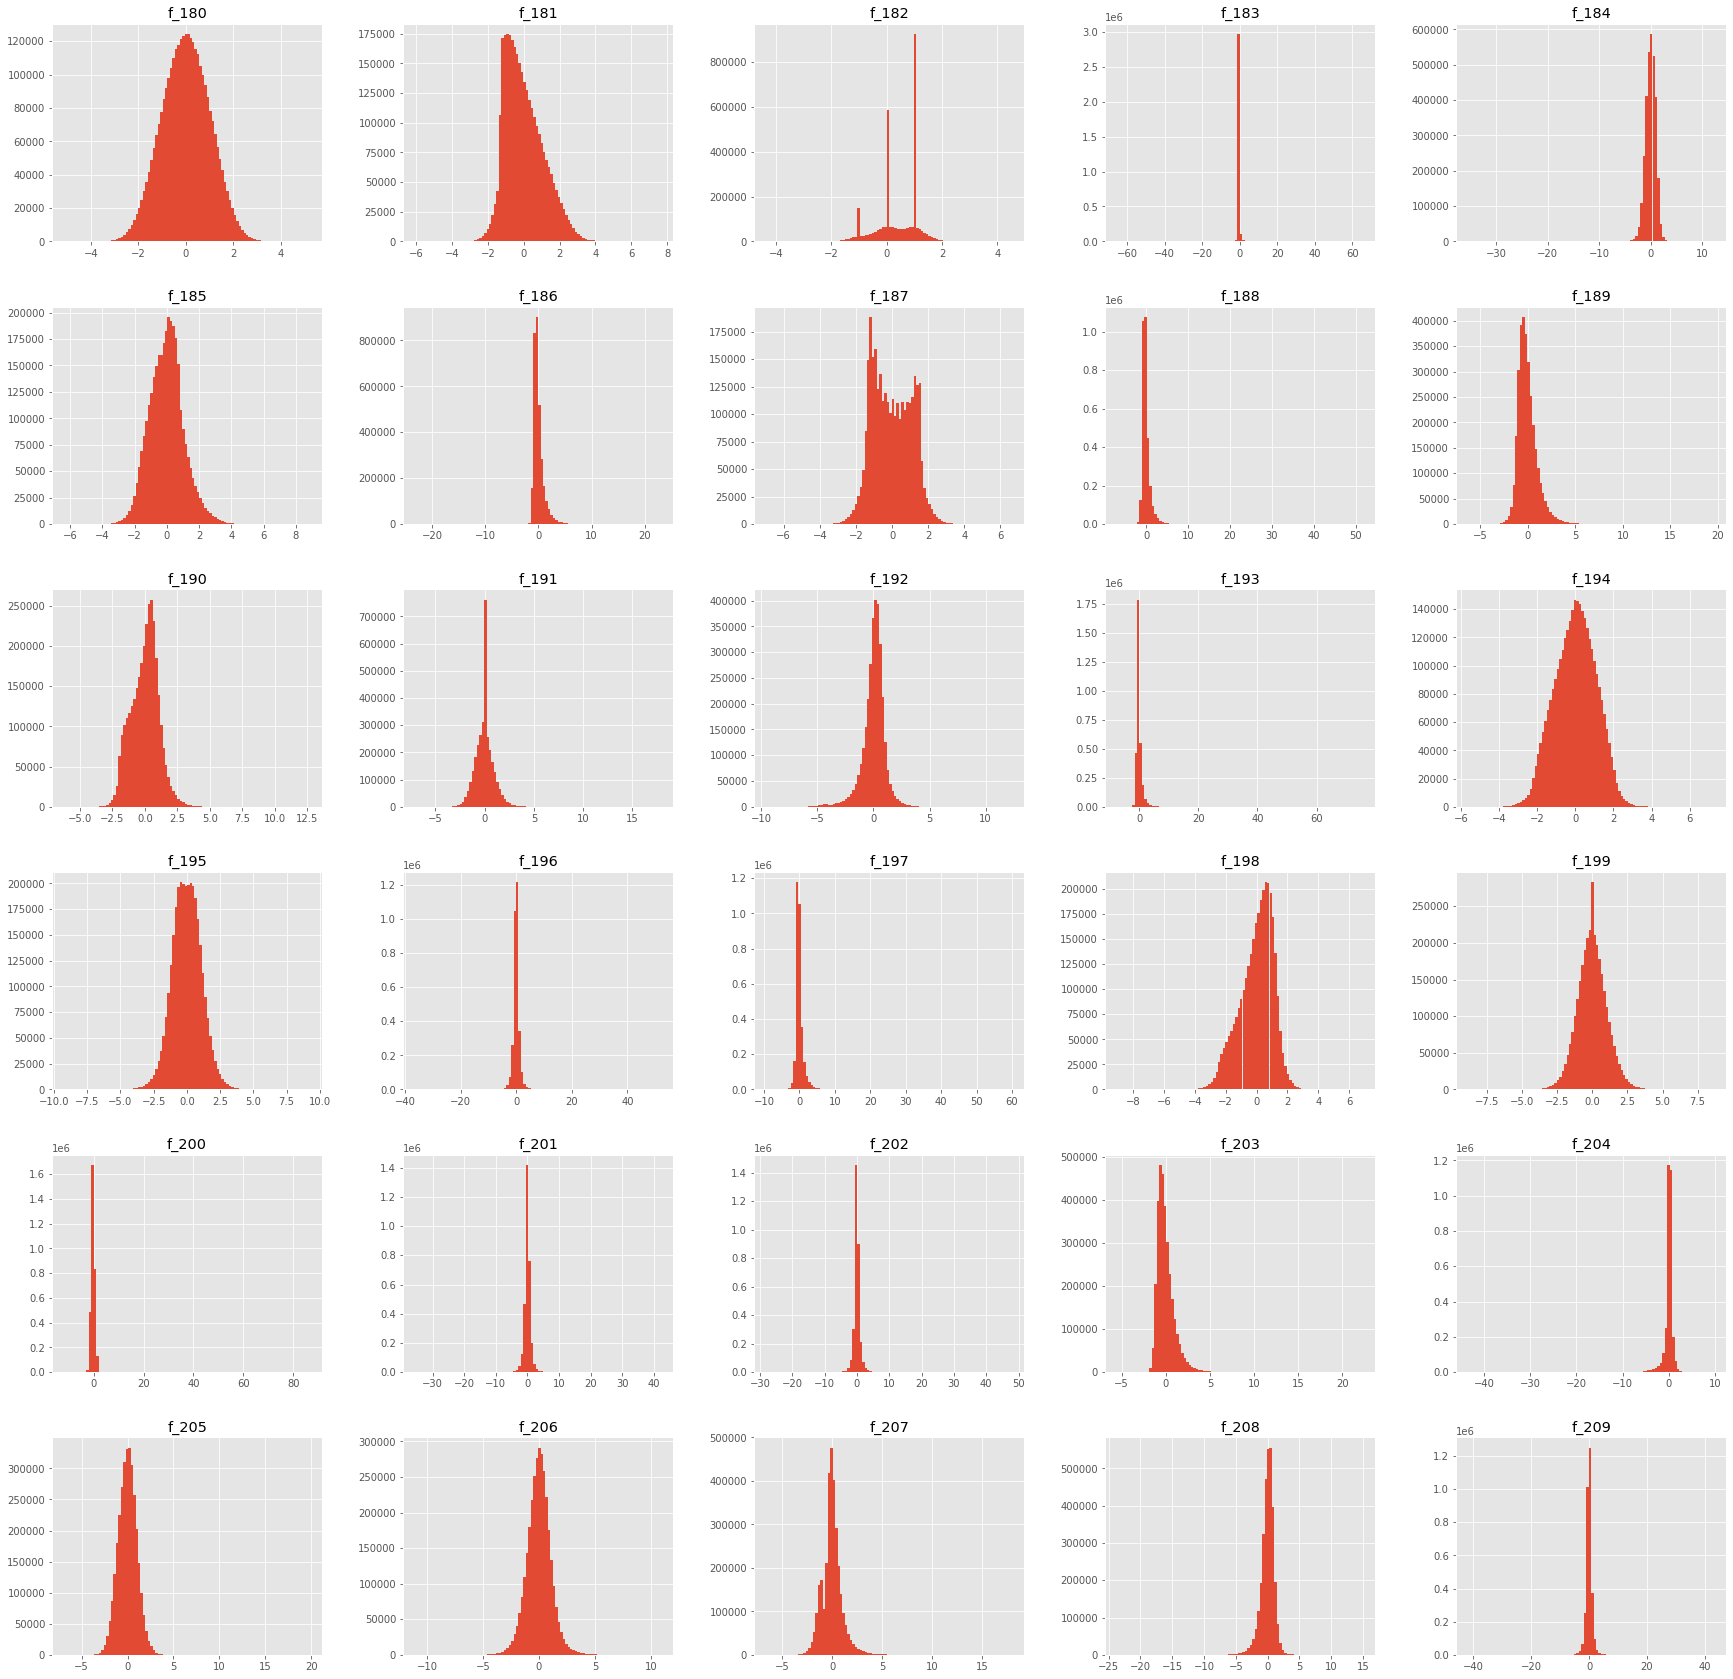

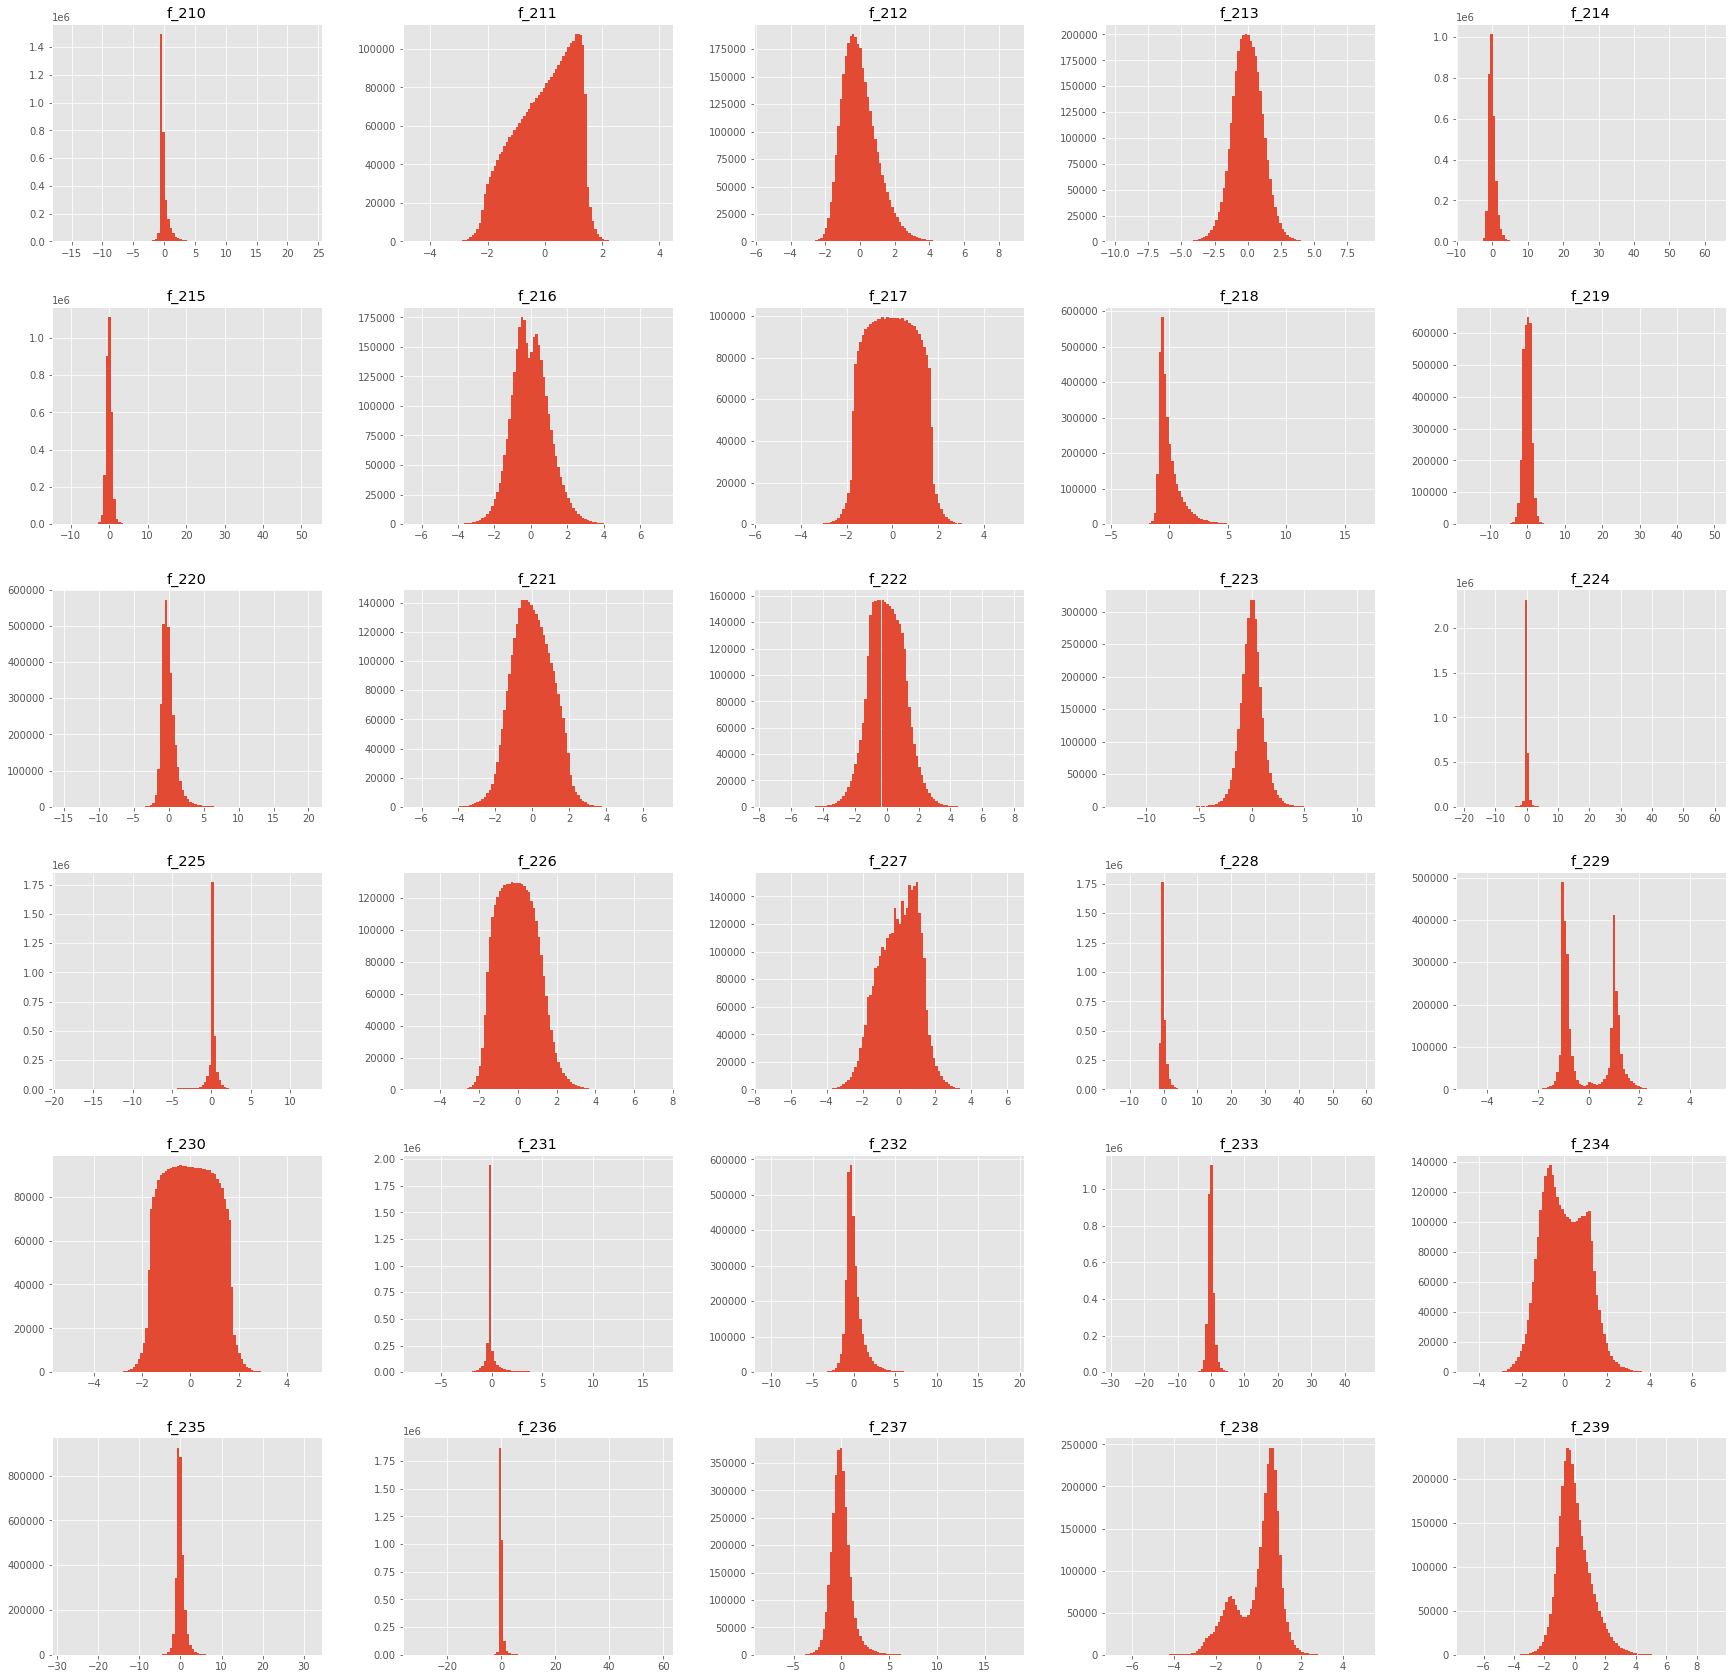

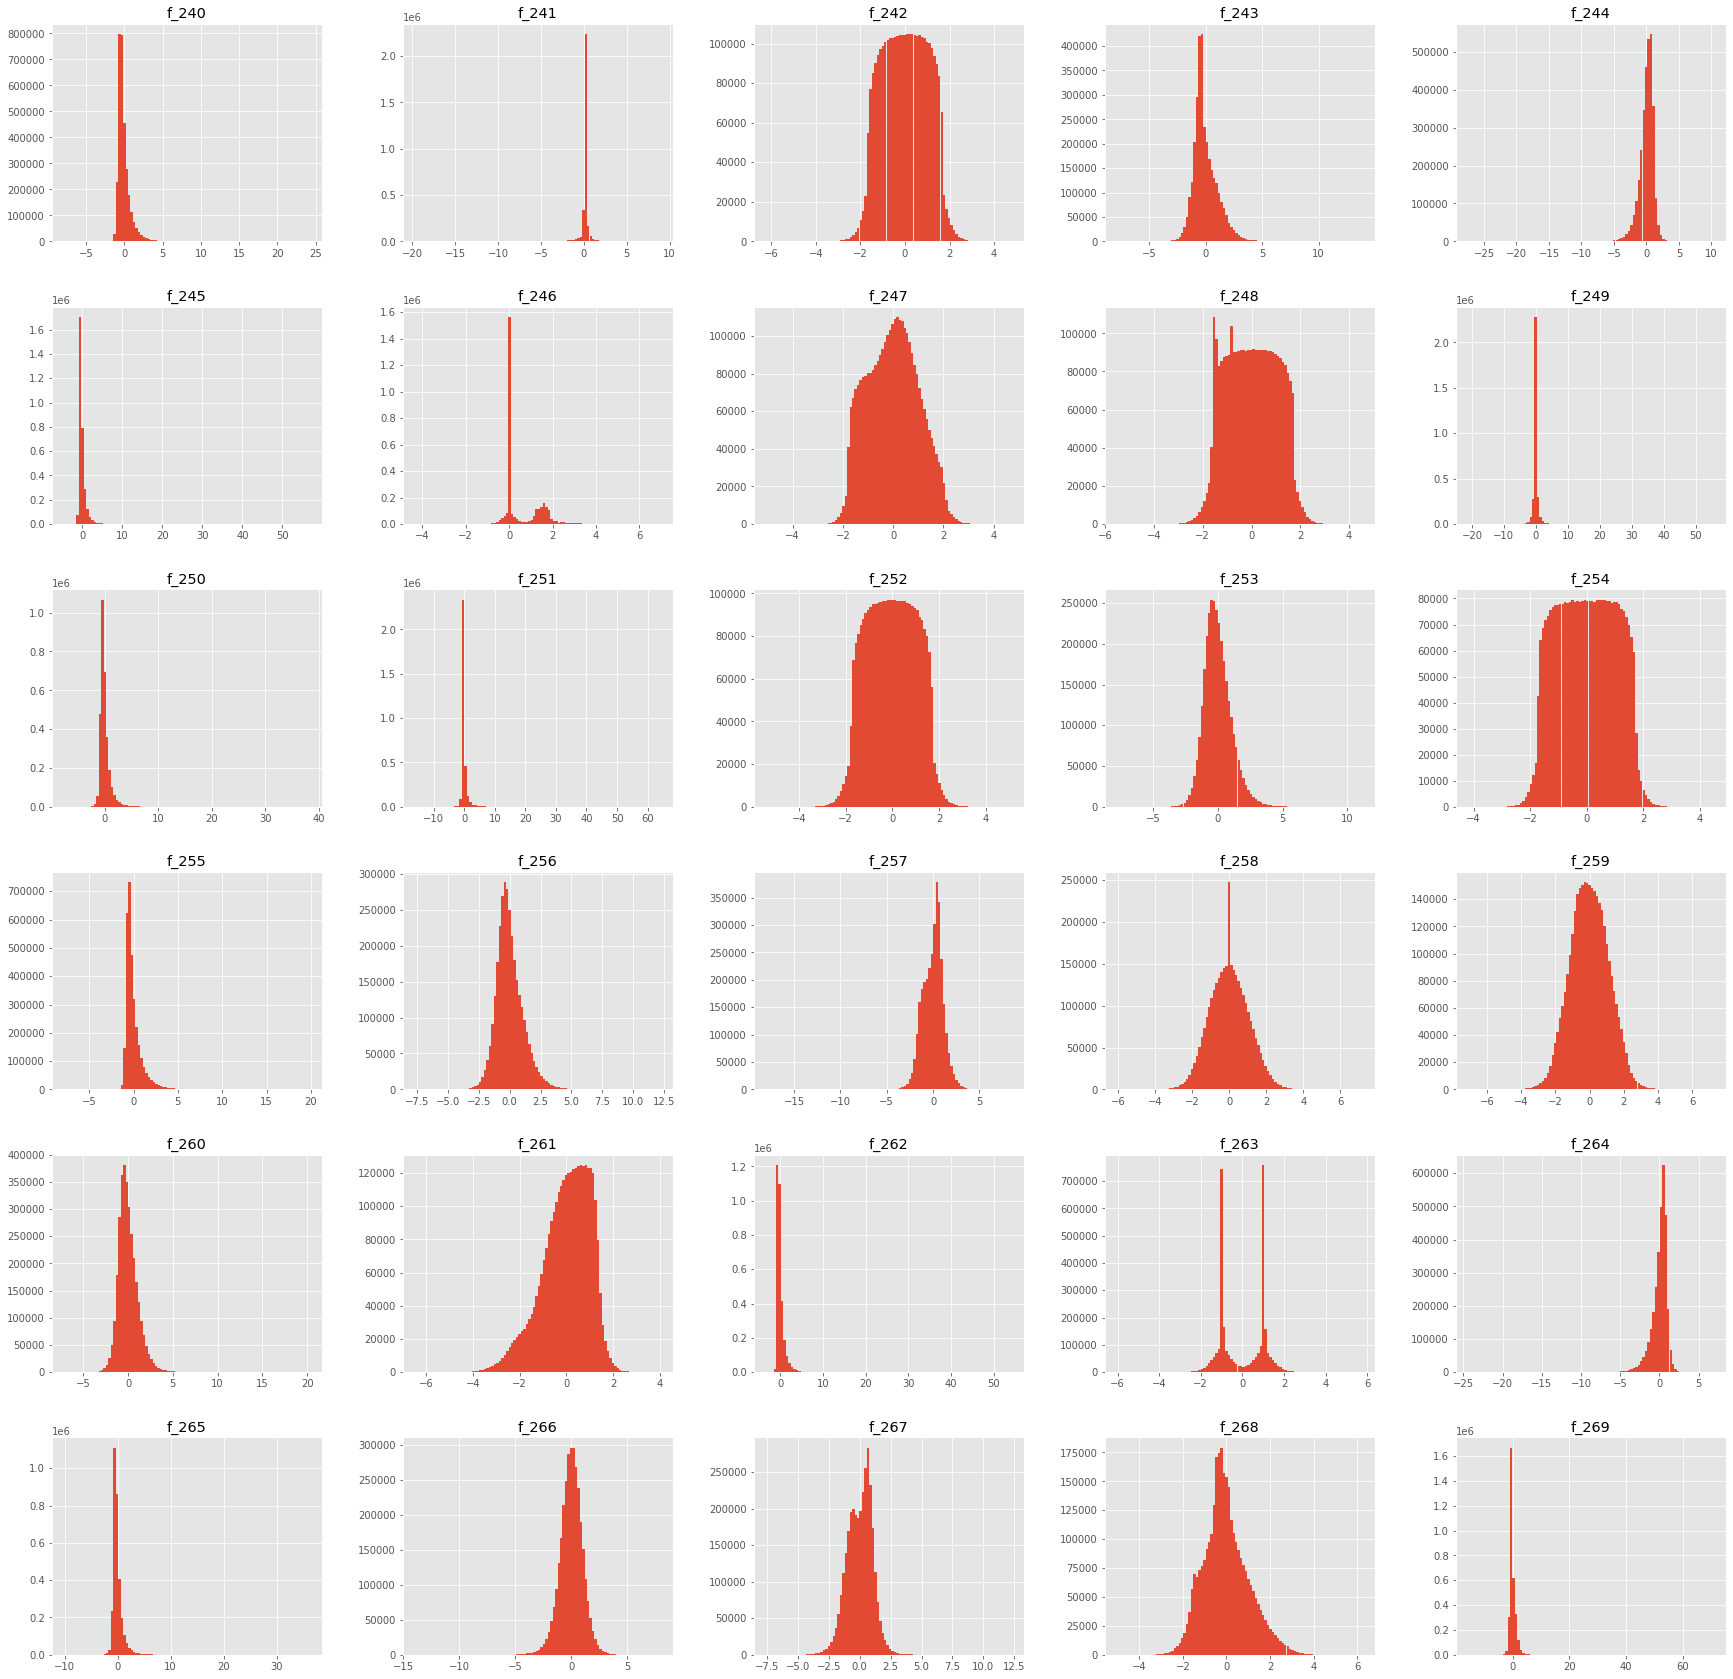

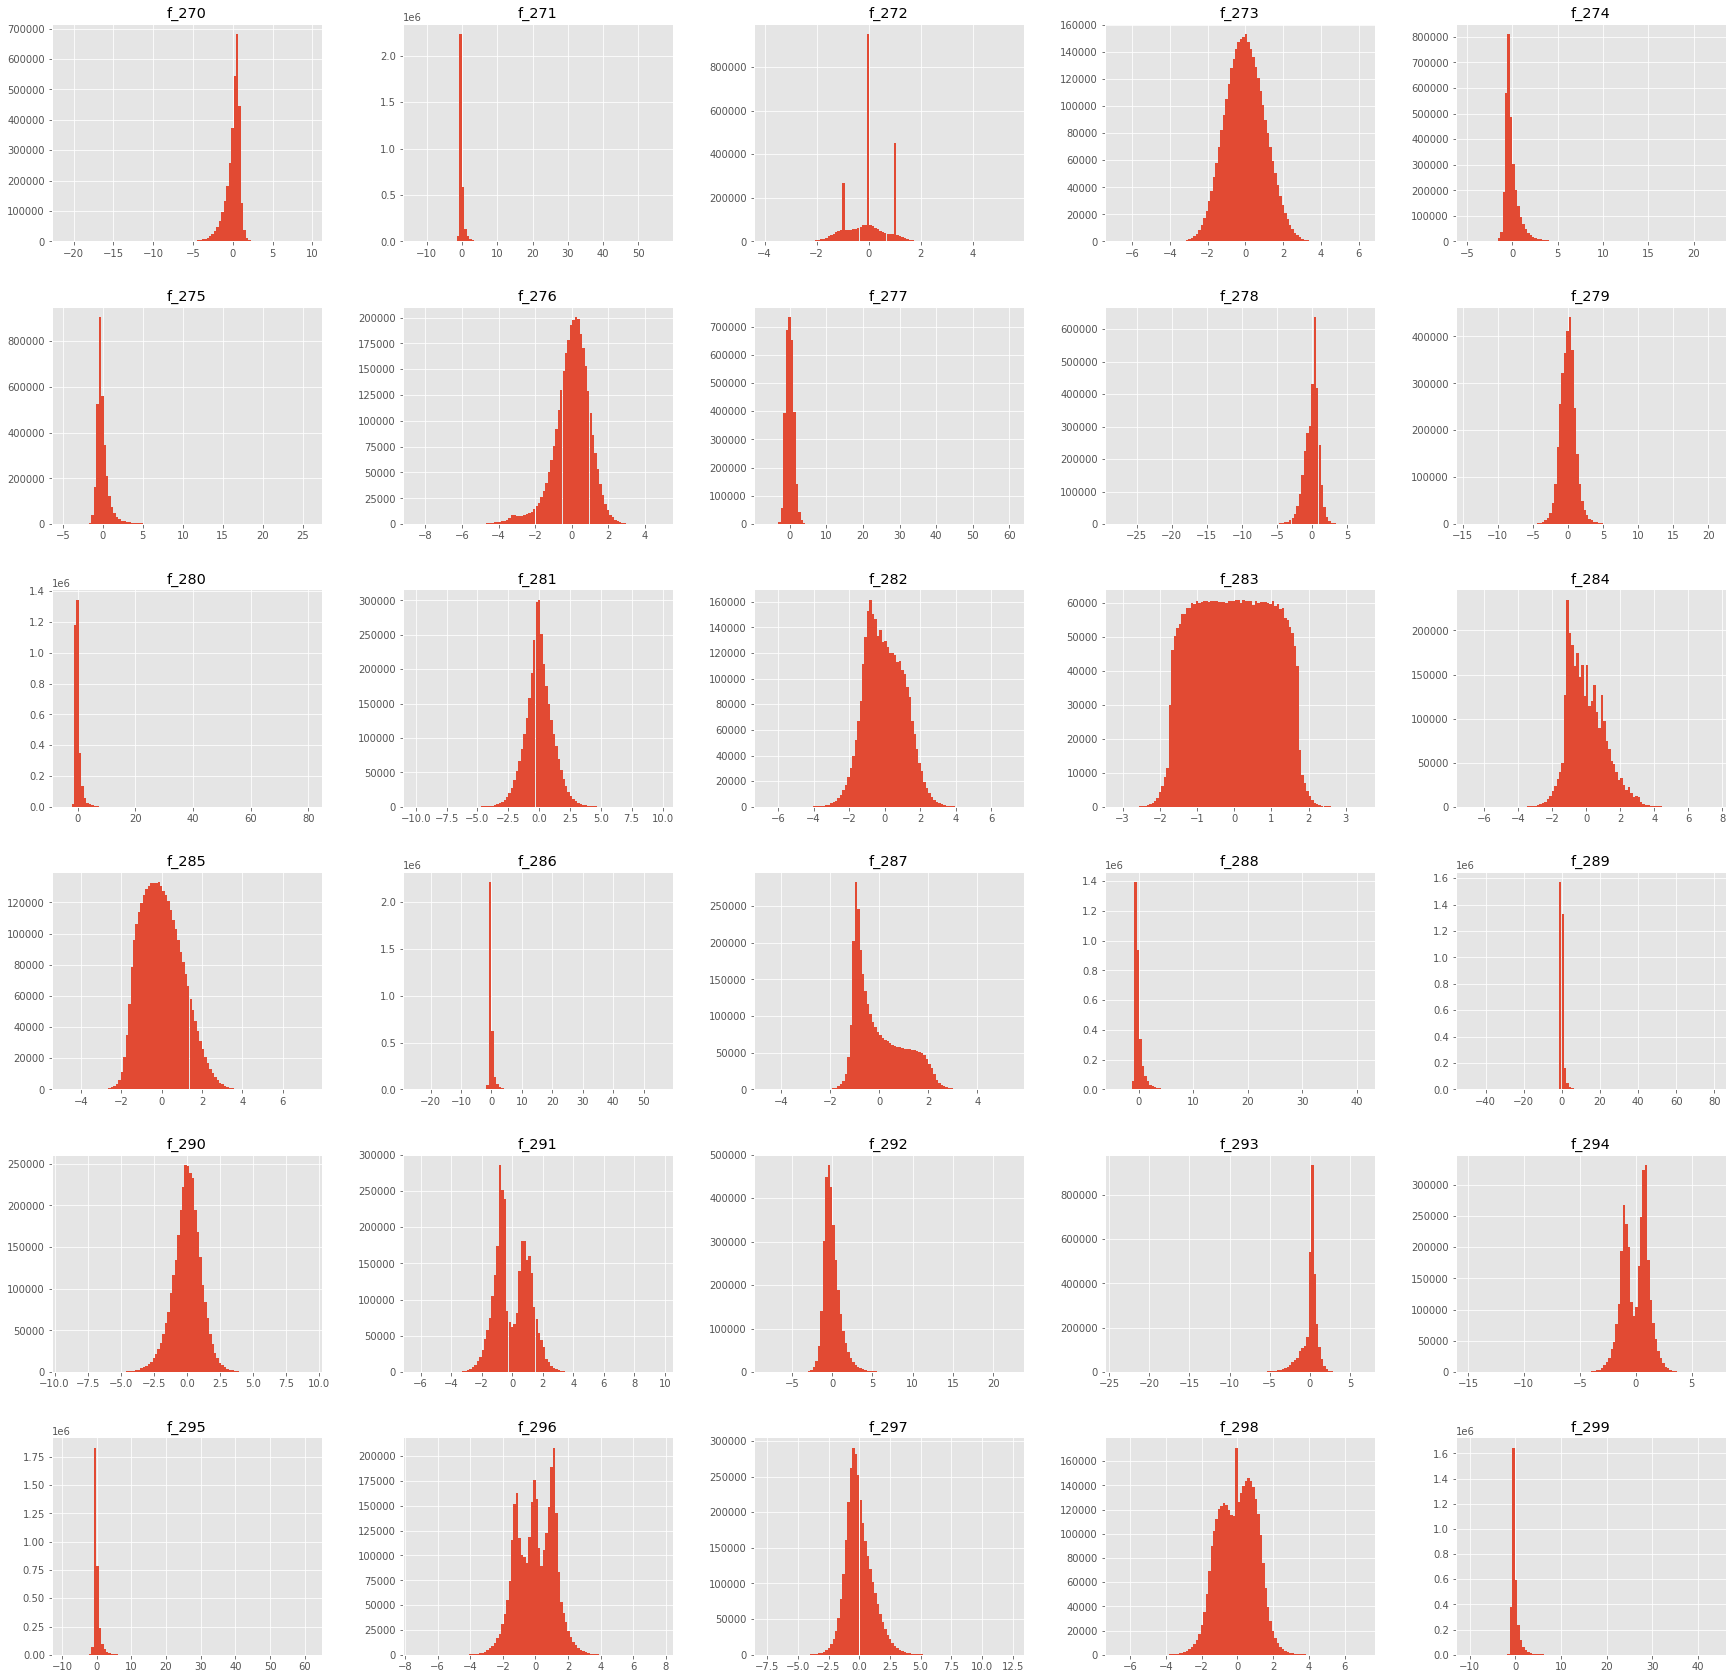

In [120]:
def plot_hist():
    '''Plot distribution of the features from f_0 to f_300
    
    '''
    for i in range(0,10):
        min_ = i*30
        max_ = 30*(i+1)
        
        columns = [f"f_{_}" for _ in range(min_,max_)]
        train.hist(column = columns, bins = 100, figsize = (30,30))
        plt.show()

    return

plot_hist()
   


Its quite difficult to make sense of the histograms of the features. There are some which exhibit a normal distribution, some which are highly skewed with long tails, and multimodal(non-uniform) distribution.

In [ ]:
# feature correlation



## Checking whether the data is static or not
We are testing whether the data is stationary or not using the Augmented Dickey-Fuller test (ADF Test). Stationarity refers to a series which doesn't exhibit seasonality or a trend. The data properties such as mean, variance, covariance are independent and not a function of time.
ADF is conducted with the following assumptions:
* *Null Hypothesis - Data is non Stationary*
* *Alternate Hypothesis - Data is stationary*

Null hypothesis is adopted if the test static is less than the critical value, and p-value is less than 0.05


In [151]:
from statsmodels.tsa.stattools import adfuller
# use ADF to test whether data is stationary or not

# test for stationarity of investment of id 70

asset = 70

d = train.query('investment_id == @asset')
d = d.set_index('time_id')['target']


def adf_test(timeseries,asset):
    '''
    returns test statistic, p-value and the critical value at 1%, 5% , 
    and 10% confidence intervals.
    
    '''
    print (f'Results of Dickey-Fuller Test: Investment_id {asset}:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print('\n\n',end='')
    
adf_test(d,asset)

Results of Dickey-Fuller Test: Investment_id 70:
Test Statistic                -1.379464e+01
p-value                        8.796067e-26
#Lags Used                     2.000000e+00
Number of Observations Used    4.760000e+02
Critical Value (1%)           -3.444163e+00
Critical Value (5%)           -2.867631e+00
Critical Value (10%)          -2.570014e+00
dtype: float64




For investment of id 70, we reject null hypothesis for alternate hypothesis. The time series is stationary from the p-value which is less than the significance level of 0.05, and the ADF statistic is less than any critical values

In [152]:
#  we perform ADF tests for more random investment ids

for i in range(5):
    asset = np.random.randint(0,train.investment_id.nunique())
    d = train.query('investment_id == @asset')
    d = d.set_index('time_id')['target']
    
    
    try:
        adf_test(d,asset)
    except err:
        print(err)
        pass

Results of Dickey-Fuller Test: Investment_id 3570:
Test Statistic                -1.552145e+01
p-value                        2.280736e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


Results of Dickey-Fuller Test: Investment_id 2062:
Test Statistic                -9.693651e+00
p-value                        1.119176e-16
#Lags Used                     4.000000e+00
Number of Observations Used    4.570000e+02
Critical Value (1%)           -3.444740e+00
Critical Value (5%)           -2.867885e+00
Critical Value (10%)          -2.570150e+00
dtype: float64


Results of Dickey-Fuller Test: Investment_id 2047:
Test Statistic                  -32.289502
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1151.000000
Critical Value (1%)      

Random investments tested above satisfy the ADF criteria for time stationarity. It can be concluded therefore that the assets in this dataset are stationary.